# **Goal: Recommendation System / Next Best Action**

## **Context**
We have a **random extraction** of a (real world) dataset containing **customers of a large wealth management company**.  

The data is **anonymous, mostly clean, and NOT always normalized/scaled**.  

Our objective is to **estimate investment needs** for these customers using **Data Science techniques**.

### **Why Estimate Investment Needs?**
Identifying customer needs is useful for several reasons, including:

* **Recommender Systems / Next Best Action:**  
  * Needs can serve as **key inputs** for **content-based** or **knowledge-based filtering algorithms**, that allows for personalized services.  
  * This is our **primary focus** in this notebook, i.e., "Know Your Client (KYC)".  

* **Product Targeting & Governance (Regulatory Compliance - MIFID/IDD in EU):**  
  * Regulatory standards require that **customer needs match the investment products offered**. So financial institutions must estimate customer needs.
  * This is essentially an **"institutional view"** of a recommendation system...

<br>

---

## **Dataset Overview**
The dataset, named **"Needs"**, is stored in an **Excel file called Dataset2_Needs.xls**.  
It contains several **potentially relevant features** along with two **target variables**, i.e:

* **AccumulationInvestment**  
  * Indicates a customer preference for **accumulation investing**, typically through **dollar-cost averaging** (i.e., investing small amounts at regular intervals over time, say on a monthly basis).  
  * **Binary (Boolean) response:**  
    * `1 = High propensity`.  
    * `0 = Low propensity`.

- **IncomeInvestment**  
  - Indicates a customer preference for **income investing**, typically through **lump-sum investing** (i.e., one-shot investments).  This is because anyone who aspires to obtain income from coupons and dividends must necessarily already have accumulated capital - a typical need of people who are older than their previous need.
  - **Binary (Boolean) response:**  
    - `1 = High propensity`.  
    - `0 = Low propensity`.  

    **Where do these two response variables come from?** From a **revealed preference scheme**: if the client has an advisor who is considered professionally reliable (this eliminates the possibility of conflict of interest) and has purchased a product that satisfies that need, and the client has also purchased it, we can say with good probability that the advisor has identified the need correctly and the client has that need. In other respects, the machine learning model we are building is a clone of the financial advisor.

<br>

Additionally, we have a **second dataset**, **"Products"**, containing investment products (funds, segregated accounts, unit-linked policies), along with:

* **Product Type:**  
  * `1 = Accumulation` (that is, a product that is good for those who have a high need for accumulation investments)
  * `0 = Income`  (that is, a product that is good for those who have a high need for income investments)

* **Risk Level:**  
  * A **normalized risk score** in the range **$[0,1]$**.  
  * This usually represents the normalized value in $[0, 1]$ of the **[Synthetic Risk and Reward Indicator (SRRI)](https://www.esma.europa.eu/sites/default/files/library/2015/11/10_673.pdf)** of the product, an ordinal variable defined in the range ${1, 7}$ starting from continuous data.

<br>

---

## **Recommendation System Approach**
The recommendation system consists of **two key steps**:

1. **Identifying customers with high investment propensity:**  
   - Using **machine learning models**, we aim to classify customers based on **AccumulationInvestment** (`1 = High propensity`) and/or **IncomeInvestment** (`1 = High propensity`).  

2. **Recommending the most suitable product for each customer:**  
   - For each customer, we match the **most appropriate product** based on:  
     - **Investment need** (Accumulation or Income).  
     - **Risk compatibility** (matching product risk level with the customer profile).  
   - This **personalized recommendation** represents the **Next Best Action** for each client.

<br>


<br>

Let's start with data ingestion.

<br>

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load each sheet into separate DataFrames
# Define the file path
file_path = 'Dataset2_Needs_fixed.xlsx'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# **Data Exploration**

As for the last business case: I keep it minimalist, for the benefit of brevity, to be able to get to the heart of the problem. But you could/can spend tons of time here in order to **understand the problem and the dataset**.

Let's display our variables to better understand the data structure and characteristics of the dataset.

<br>

In [3]:
# Let's see the actual variables names in metadata_df
print("Metadata DataFrame columns:")
print(metadata_df.columns.tolist())

# Let's peek at the first few rows
print("\nFirst few rows of metadata:")
print(metadata_df.head())


Metadata DataFrame columns:
['Metadata', 'Unnamed: 1']

First few rows of metadata:
        Metadata                     Unnamed: 1
0        Clients                            NaN
1             ID                   Numerical ID
2            Age                  Age, in years
3         Gender  Gender (Female = 1, Male = 0)
4  FamilyMembers           Number of components


<br>

We drop ID column as it's not needed for analysis.

<br>

In [4]:
# Fix compatibility issue between newer matplotlib and pandas
import matplotlib as mpl
if hasattr(mpl, 'colormaps') and not hasattr(mpl.colormaps, 'get_cmap'):
    def get_cmap(name):
        return mpl.colormaps[name]
    mpl.colormaps.get_cmap = get_cmap

# Drop ID column and create comprehensive summary
needs_df_no_id = needs_df.drop('ID', axis=1)

# Create enhanced summary statistics
def get_statistics(series):
    stats = {
        'Count': len(series),
        'Unique Values': series.nunique(),
        'Missing Values': series.isnull().sum(),
        'Mean': series.mean(),
        'Median': series.median(),
        'Mode': series.mode().iloc[0] if not series.mode().empty else None,
        'Std Dev': series.std(),
        'Variance': series.var(),
        'Min': series.min(),
        '25th Percentile': series.quantile(0.25),
        '75th Percentile': series.quantile(0.75),
        'Max': series.max(),
        'Range': series.max() - series.min(),
        'IQR': series.quantile(0.75) - series.quantile(0.25),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis(),
        'Outliers (IQR)': len(series[((series < (series.quantile(0.25) - 1.5 * (series.quantile(0.75) - series.quantile(0.25)))) | 
                                    (series > (series.quantile(0.75) + 1.5 * (series.quantile(0.75) - series.quantile(0.25)))))]),
        'CV': (series.std() / series.mean()) * 100 if series.mean() != 0 else None
    }
    return stats

# Calculate statistics for each column
summary_data = []
for column in needs_df_no_id.columns:
    stats = get_statistics(needs_df_no_id[column])
    stats['Column'] = column
    summary_data.append(stats)

# Create DataFrame with statistics
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Column')

# Round numeric columns to 2 decimal places
numeric_columns = summary_df.select_dtypes(include=[np.number]).columns
summary_df[numeric_columns] = summary_df[numeric_columns].round(2)

# Display the summary table with styling
styled_summary = summary_df.style\
    .format(precision=2)\
    .background_gradient(cmap='YlOrRd', subset=['Missing Values'])\
    .background_gradient(cmap='YlOrRd', subset=['Skewness'])\
    .background_gradient(cmap='YlOrRd', subset=['Kurtosis'])\
    .background_gradient(cmap='YlOrRd', subset=['Outliers (IQR)'])\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'caption', 'props': [('caption-side', 'top')]}
    ])\
    .set_caption('Enhanced Dataset Summary Statistics (Excluding ID)')

display(styled_summary)

# Print additional insights with better formatting
print("\nKey Insights:")
print("1. Target Variables Distribution:")
income_dist = needs_df_no_id['IncomeInvestment'].value_counts(normalize=True).round(3) * 100
accum_dist = needs_df_no_id['AccumulationInvestment'].value_counts(normalize=True).round(3) * 100
print(f"   - IncomeInvestment:")
print(f"     * Yes: {income_dist[1]:.1f}%")
print(f"     * No:  {income_dist[0]:.1f}%")
print(f"   - AccumulationInvestment:")
print(f"     * Yes: {accum_dist[1]:.1f}%")
print(f"     * No:  {accum_dist[0]:.1f}%")

print("\n2. Feature Characteristics:")
print(f"   - Age Range: {needs_df_no_id['Age'].min()} to {needs_df_no_id['Age'].max()} years")
print(f"   - Wealth Range: {needs_df_no_id['Wealth'].min():.2f} to {needs_df_no_id['Wealth'].max():.2f}")
print(f"   - Family Size: {needs_df_no_id['FamilyMembers'].min()} to {needs_df_no_id['FamilyMembers'].max()} members")

print("\n3. Data Quality:")
print(f"   - Missing Values: {needs_df_no_id.isnull().sum().sum()}")
print(f"   - Duplicate Rows: {needs_df_no_id.duplicated().sum()}")

print("\n4. Distribution Insights:")
for col in needs_df_no_id.select_dtypes(include=[np.number]).columns:
    skew = needs_df_no_id[col].skew()
    kurt = needs_df_no_id[col].kurtosis()
    outliers = summary_df.loc[col, 'Outliers (IQR)']
    print(f"   - {col}:")
    print(f"     * Skewness: {skew:.2f} ({'Right-skewed' if skew > 0 else 'Left-skewed' if skew < 0 else 'Symmetric'})")
    print(f"     * Kurtosis: {kurt:.2f} ({'Heavy-tailed' if kurt > 0 else 'Light-tailed' if kurt < 0 else 'Normal-like'})")
    print(f"     * Outliers: {outliers} ({outliers/len(needs_df_no_id)*100:.1f}% of data)")

,Count,Unique Values,Missing Values,Mean,Median,Mode,Std Dev,Variance,Min,25th Percentile,75th Percentile,Max,Range,IQR,Skewness,Kurtosis,Outliers (IQR),CV
Column,,,,,,,,,,,,,,,,,,
Age,5000,77,0,55.25,55.00,59.00,11.97,143.32,18.00,47.00,63.00,97.00,79.00,16.00,0.06,-0.03,29,21.67
Gender,5000,2,0,0.49,0.00,0.00,0.50,0.25,0.00,0.00,1.00,1.00,1.00,1.00,0.03,-2.00,0,101.62
FamilyMembers,5000,5,0,2.51,3.00,2.00,0.76,0.58,1.00,2.00,3.00,5.00,4.00,1.00,0.06,-0.21,11,30.35
FinancialEducation,5000,5000,0,0.42,0.42,0.04,0.15,0.02,0.04,0.31,0.52,0.90,0.87,0.22,0.15,-0.42,8,36.12
RiskPropensity,5000,5000,0,0.36,0.35,0.02,0.15,0.02,0.02,0.25,0.47,0.88,0.86,0.22,0.33,-0.35,10,41.67
Income,5000,5000,0,62.99,53.40,1.54,44.36,1967.79,1.54,30.60,84.12,365.32,363.79,53.53,1.38,2.86,166,70.42
Wealth,5000,5000,0,93.81,66.07,1.06,105.47,11124.13,1.06,38.31,114.82,2233.23,2232.17,76.51,5.83,67.13,317,112.43
IncomeInvestment,5000,2,0,0.38,0.00,0.00,0.49,0.24,0.00,0.00,1.00,1.00,1.00,1.00,0.48,-1.77,0,126.78
AccumulationInvestment,5000,2,0,0.51,1.00,1.00,0.50,0.25,0.00,0.00,1.00,1.00,1.00,1.00,-0.05,-2.00,0,97.40



Key Insights:
1. Target Variables Distribution:
   - IncomeInvestment:
     * Yes: 38.4%
     * No:  61.6%
   - AccumulationInvestment:
     * Yes: 51.3%
     * No:  48.7%

2. Feature Characteristics:
   - Age Range: 18 to 97 years
   - Wealth Range: 1.06 to 2233.23
   - Family Size: 1 to 5 members

3. Data Quality:
   - Missing Values: 0
   - Duplicate Rows: 0

4. Distribution Insights:
   - Age:
     * Skewness: 0.06 (Right-skewed)
     * Kurtosis: -0.03 (Light-tailed)
     * Outliers: 29 (0.6% of data)
   - Gender:
     * Skewness: 0.03 (Right-skewed)
     * Kurtosis: -2.00 (Light-tailed)
     * Outliers: 0 (0.0% of data)
   - FamilyMembers:
     * Skewness: 0.06 (Right-skewed)
     * Kurtosis: -0.21 (Light-tailed)
     * Outliers: 11 (0.2% of data)
   - FinancialEducation:
     * Skewness: 0.15 (Right-skewed)
     * Kurtosis: -0.42 (Light-tailed)
     * Outliers: 8 (0.2% of data)
   - RiskPropensity:
     * Skewness: 0.33 (Right-skewed)
     * Kurtosis: -0.35 (Light-tailed)
     *

In [5]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
ID,Numerical ID,2500.50,1443.52,0,1.00,5000.00
Age,"Age, in years",55.25,11.97,0,18.00,97.00
Gender,"Gender (Female = 1, Male = 0)",0.49,0.50,0,0.00,1.00
FamilyMembers,Number of components,2.51,0.76,0,1.00,5.00
FinancialEducation,Normalized level of Financial Education (estimate),0.42,0.15,0,0.04,0.90
RiskPropensity,Normalized Risk propensity from MIFID profile,0.36,0.15,0,0.02,0.88
Income,Income (thousands of euros); estimate,62.99,44.36,0,1.54,365.32
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,93.81,105.47,0,1.06,2233.23
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,0.38,0.49,0,0.00,1.00
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,0.51,0.50,0,0.00,1.00



PRODUCTS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
IDProduct,Product description,6.00,3.32,0,1.00,11.00
Type,"1 = Accumulation product, 0 = Income product",0.64,0.50,0,0.00,1.00
Risk,Normalized Synthetic Risk Indicator,0.43,0.24,0,0.12,0.88


<br>

## Data Transformation and Exploratory Analysis

### 1. Initial setup
* Import required libraries (seaborn, matplotlib, etc).
* Create utility function for histogram plotting.

### 2. Target variables analysis: are they imbalanced?
* Visualize distribution of Income Investment needs.
* Visualize distribution of Accumulation Investment needs.
* Assess class balance for both target variables.

### 3. Wealth variable transformation analysis: is it too fat-tailed?
Display the fat-tailed shape of the Wealth variable, and effect of a couple of reasonable transformations on the Wealth variable. We examine three versions of the Wealth variable:
* Original Wealth distribution.
* Log transformation.
* Power transformation (0.1 power).
* Evaluate which transformation better normalizes the distribution, identifying the most appropriate transformation for leptokurtic, skewed wealth data.

### 4. Some feature engineering and scaling
* Apply log transformation to Wealth and Income.
* Normalize selected variables using MinMaxScaler.
* Create a standardized feature set for modeling.

### 5. Multivariate analysis
* Generate a correlation matrix heatmap for all numeric variables.
* Create pairwise relationships visualization.
* Examine relationships between transformed variables and target variables.

<br>


CREATING BASELINE DATASET
Dataset shape: (5000, 9)
Target distribution - Income Investment: 
IncomeInvestment
0    61.6
1    38.4
Name: proportion, dtype: float64%
Target distribution - Accumulation Investment: 
AccumulationInvestment
1    51.3
0    48.7
Name: proportion, dtype: float64%

Baseline Dataset Summary:
Number of features: 9
Feature list: ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Wealth_log', 'Income_log']


CREATING FEATURE-ENGINEERED DATASET
Visualizing original data distributions...


/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/sea

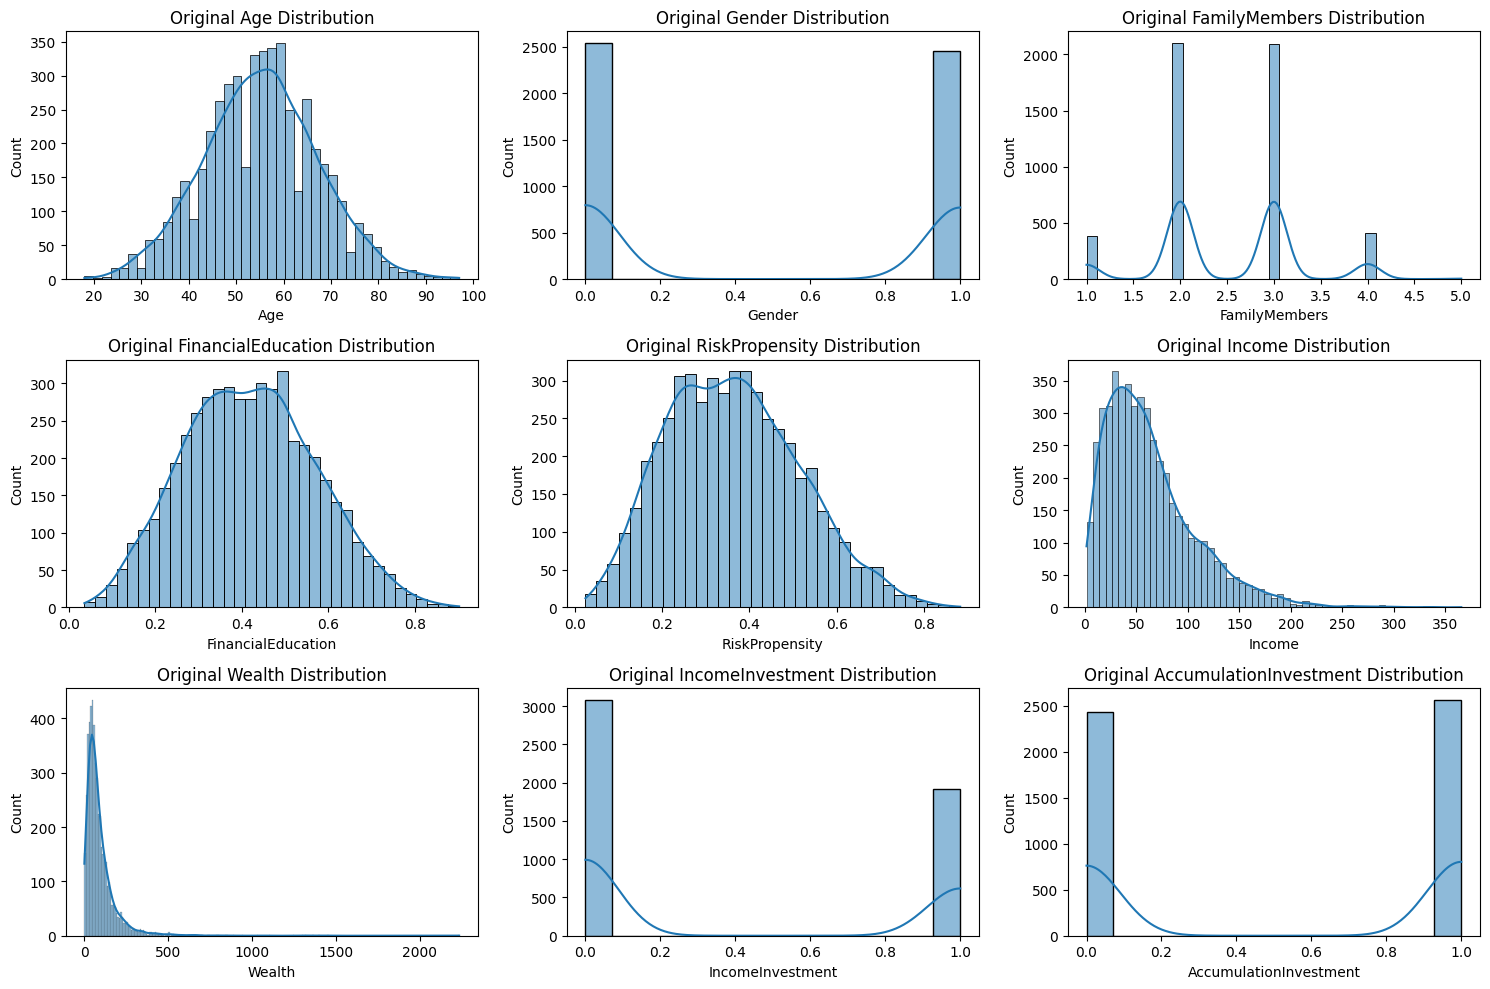


Generating box plots to identify outliers...


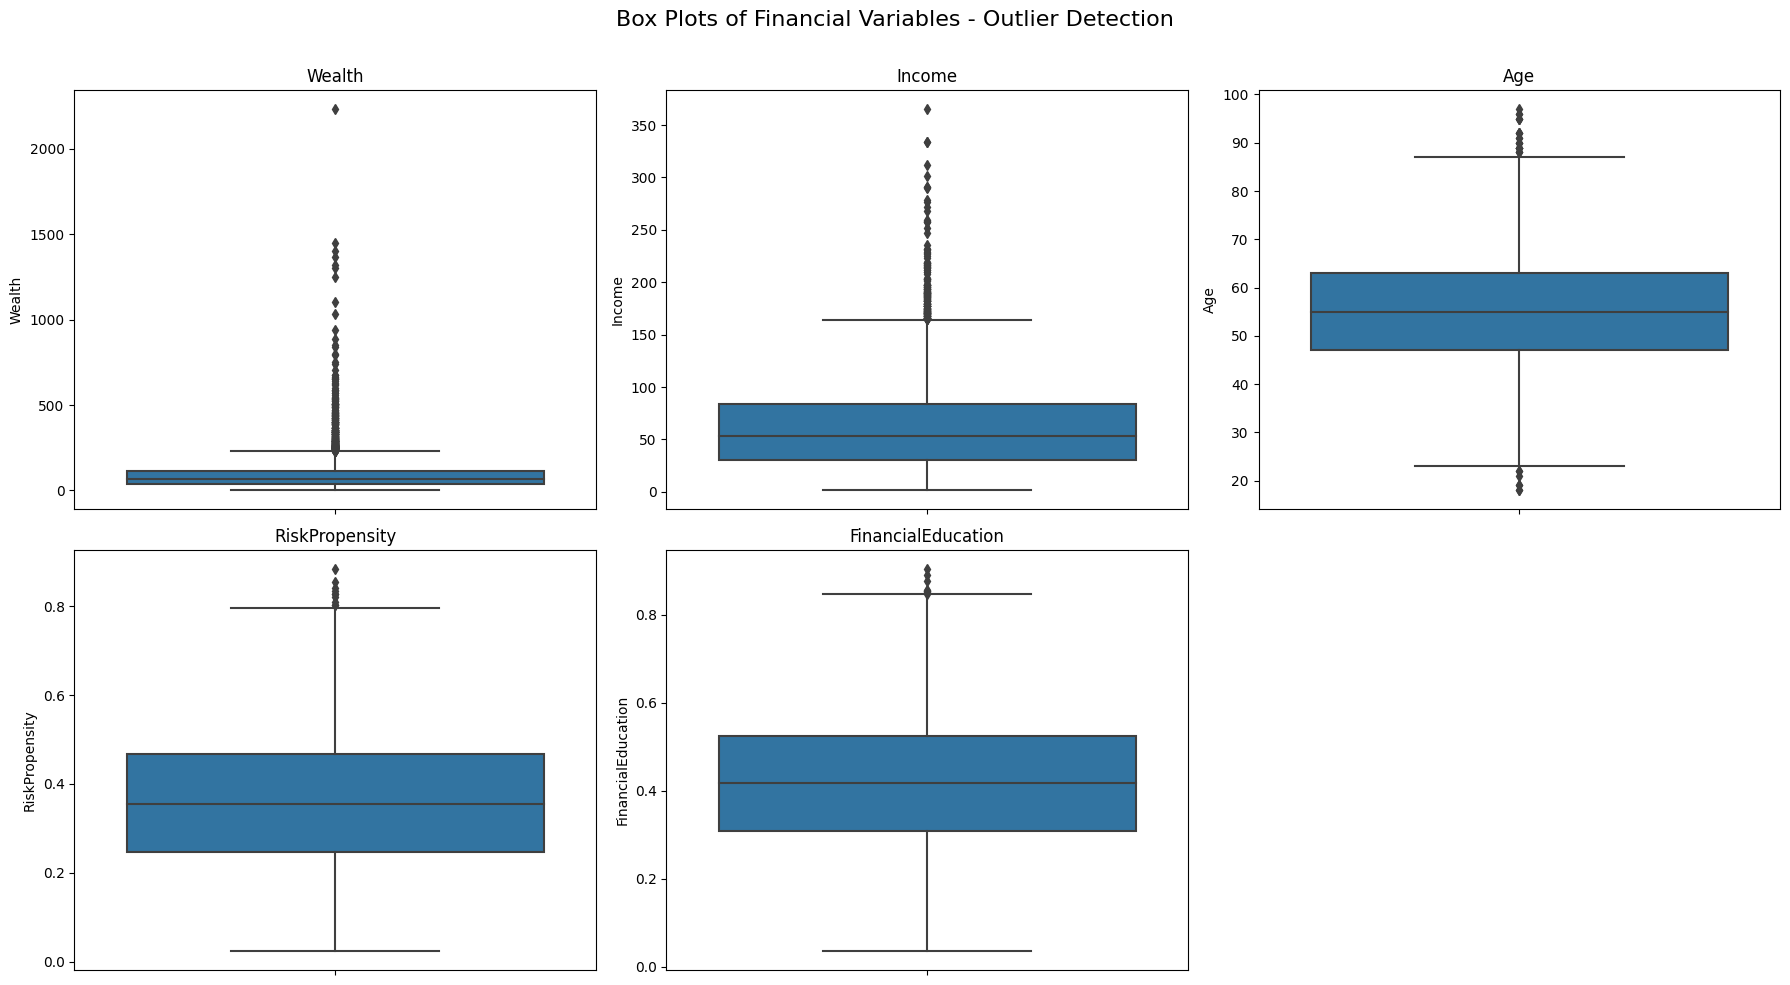

Correlation between Incomeand Accumulation Investment needs: 0.011


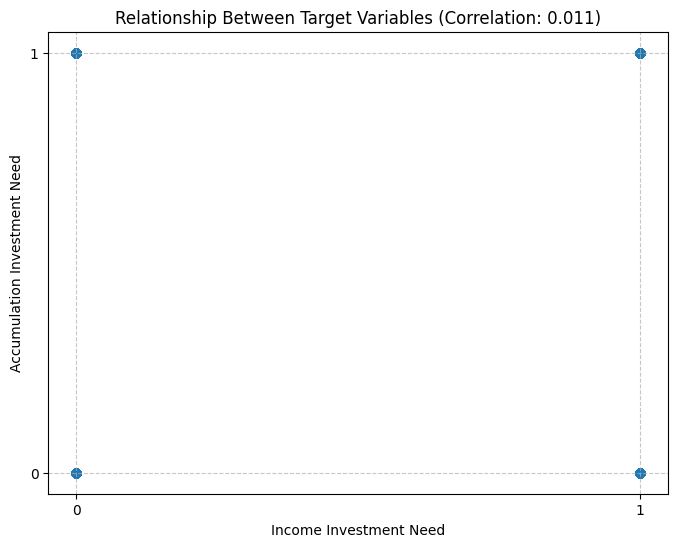


Performing advanced feature engineering...


/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


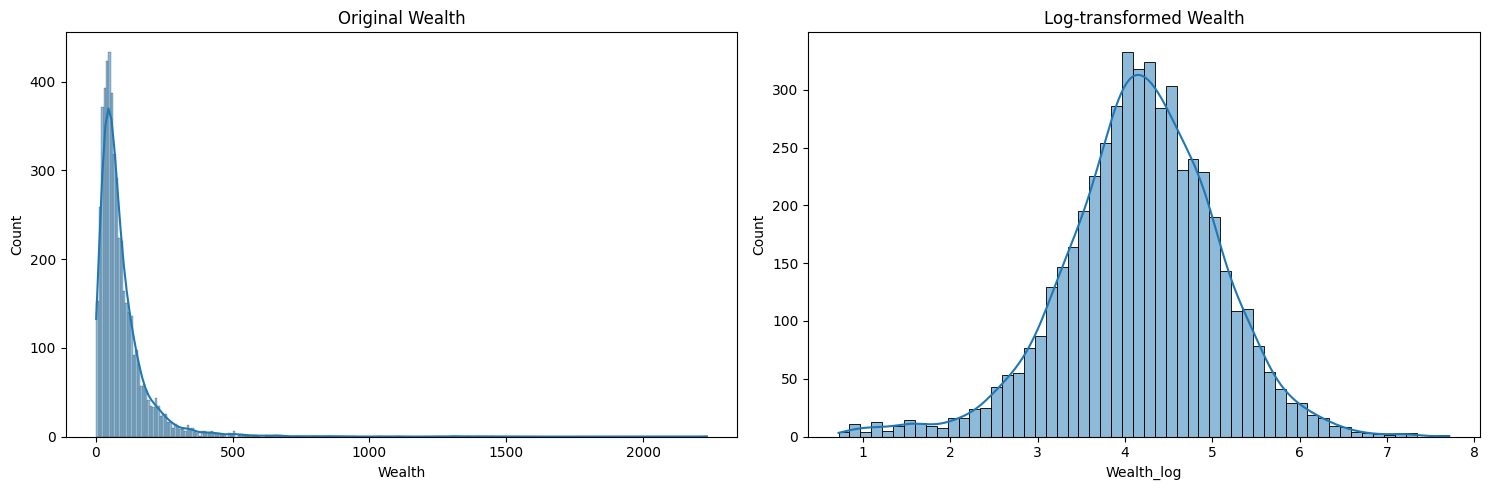

/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


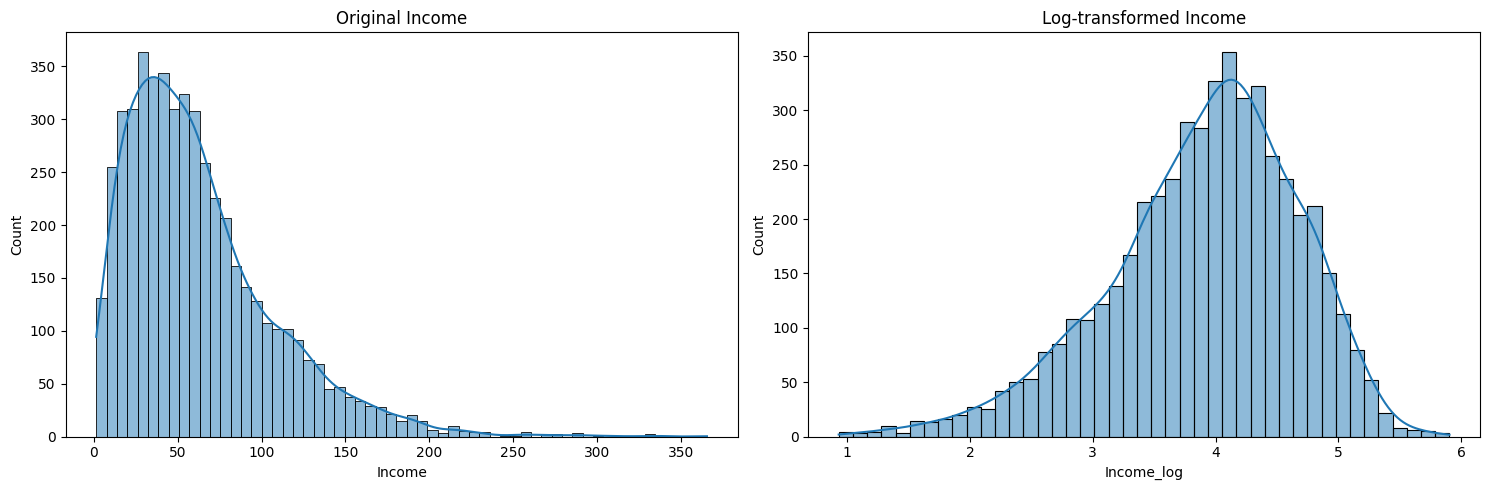

/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


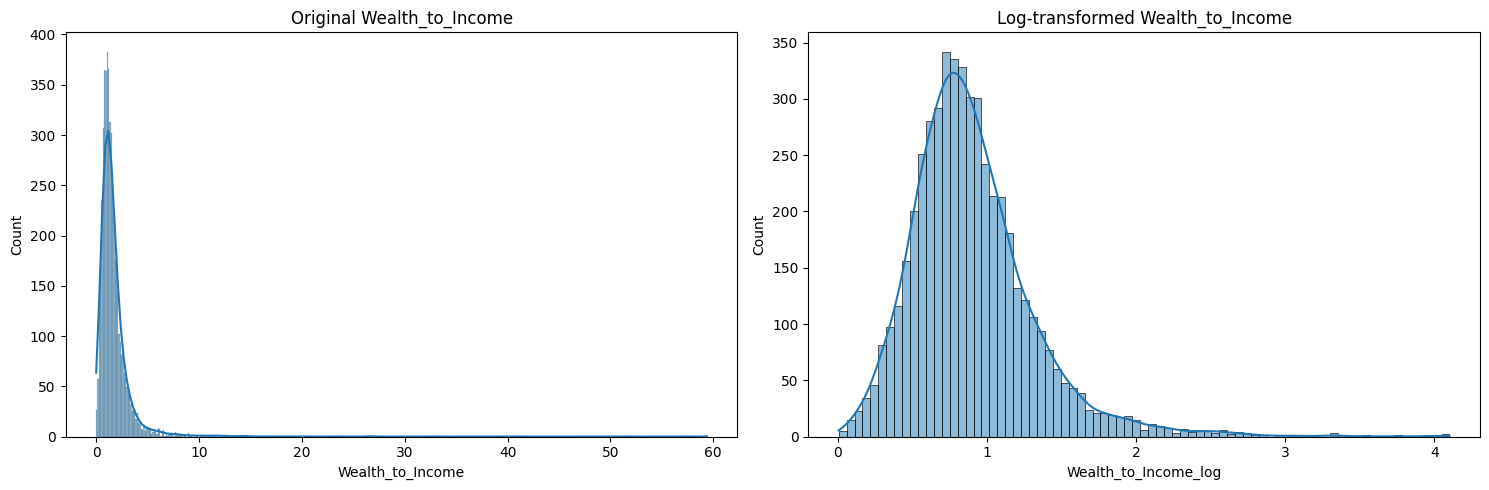

/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


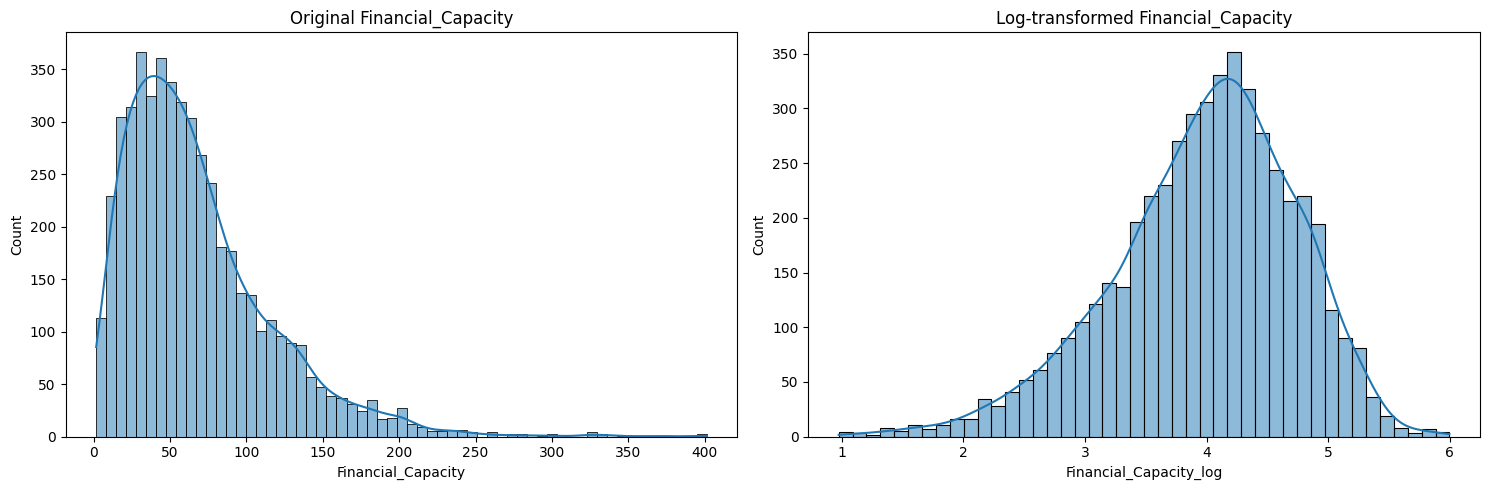

/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


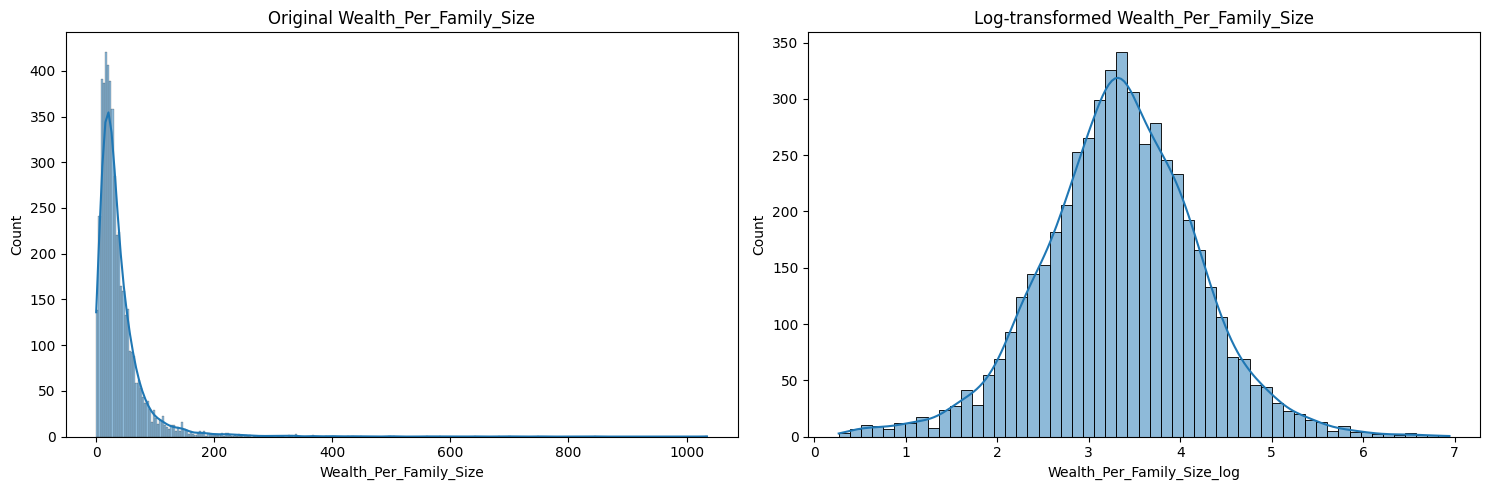

/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouadh/Fintech_Projects/Business_Case_2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


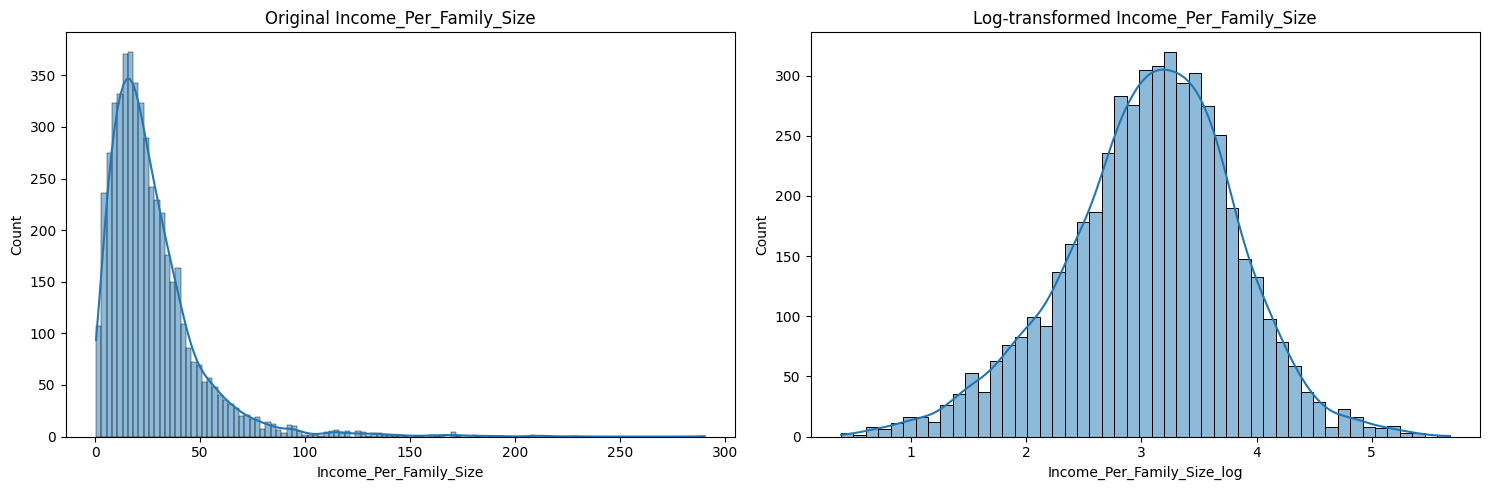

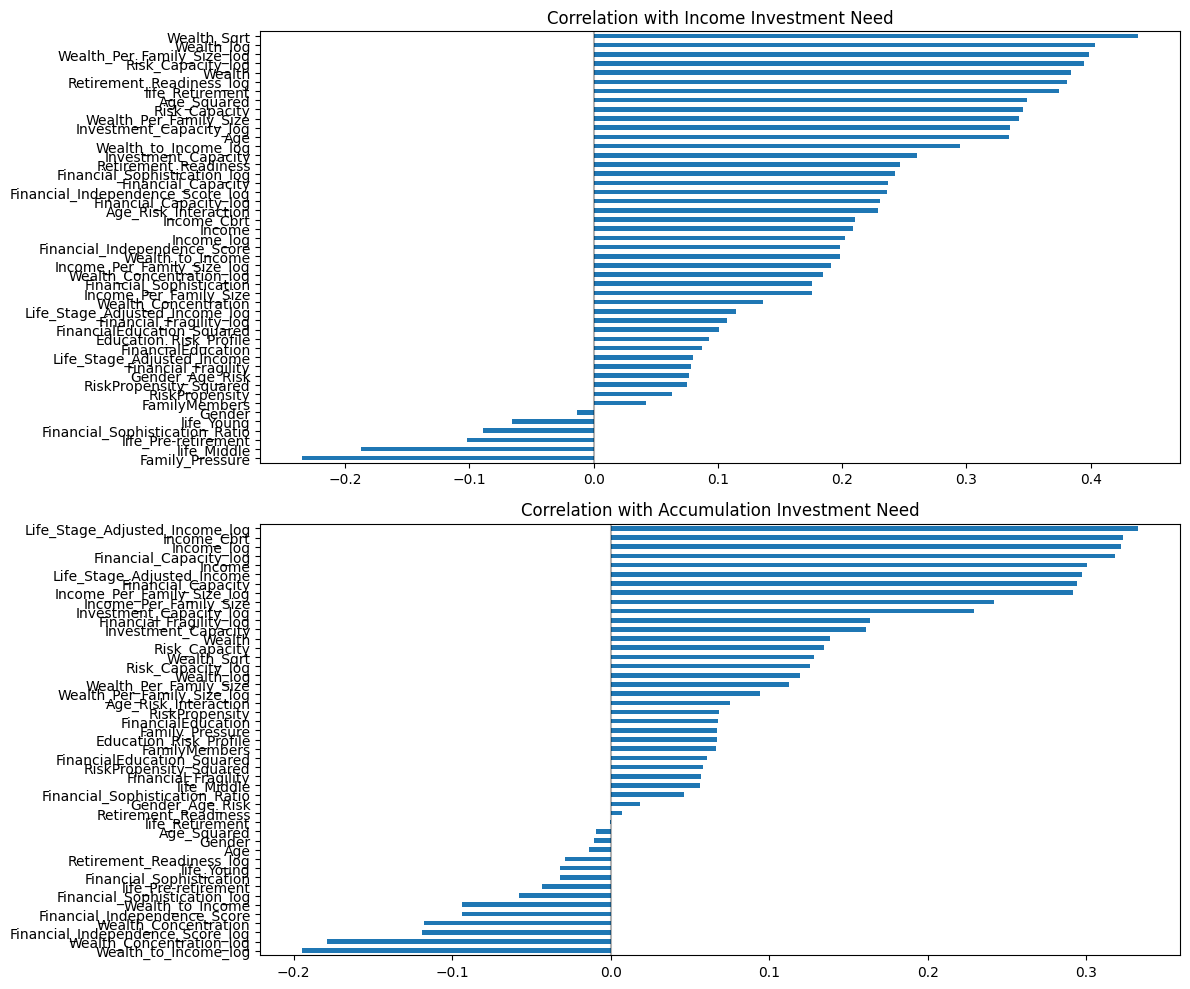

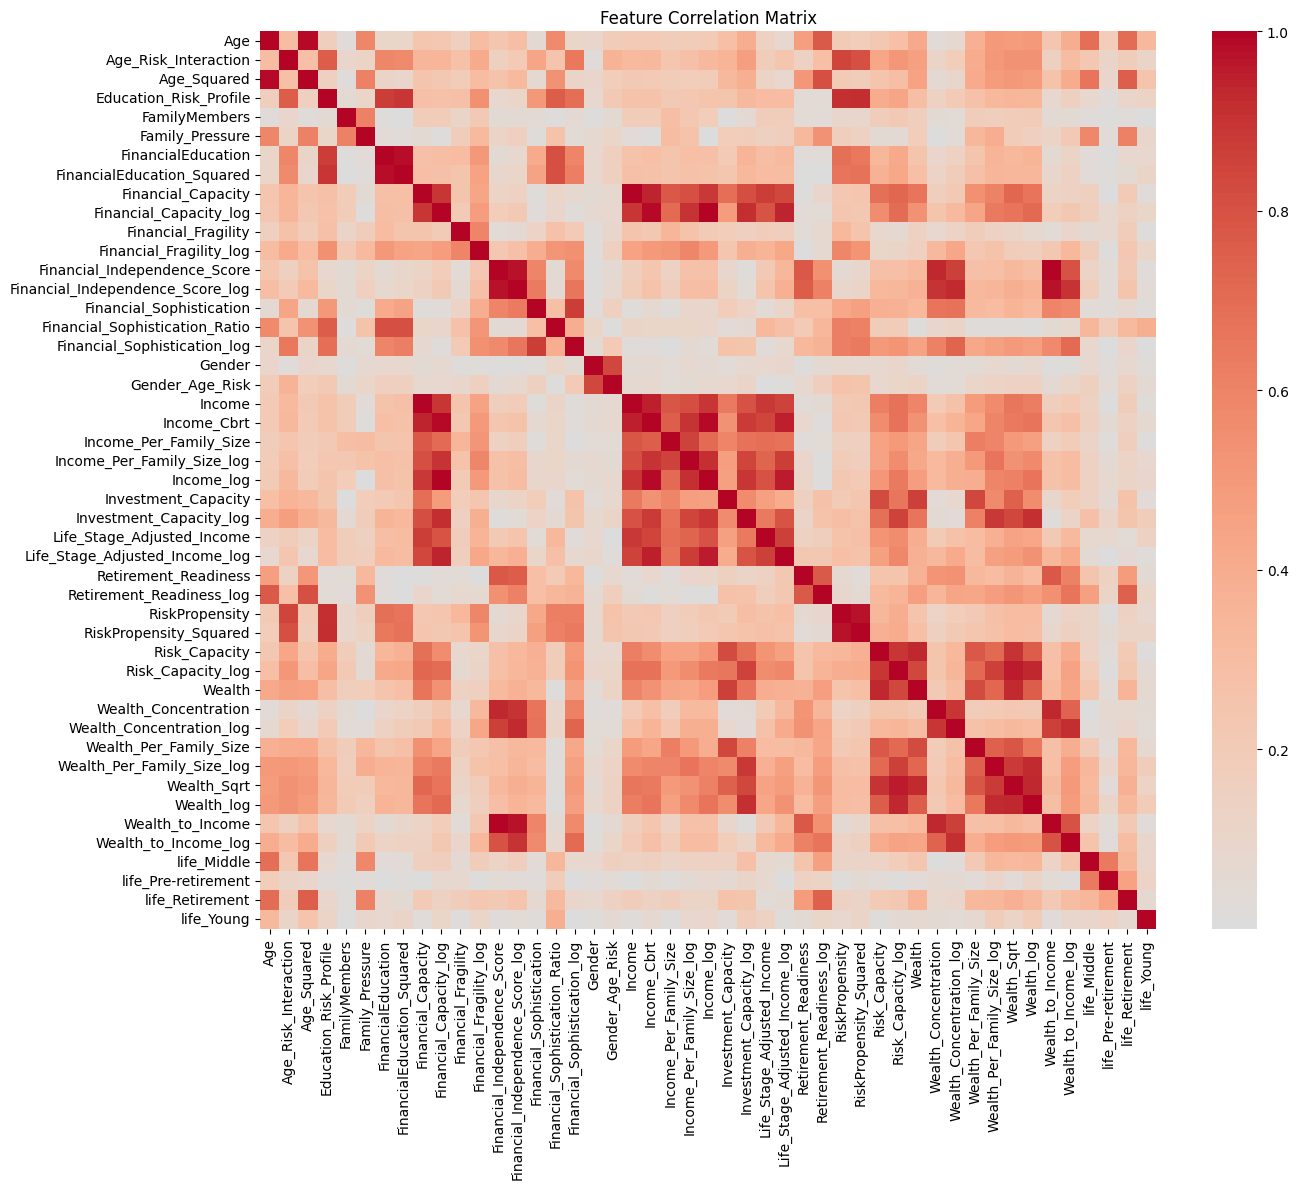


Highly correlated feature pairs (>0.9):
Age - Age_Squared: 0.989
Education_Risk_Profile - RiskPropensity: 0.908
Education_Risk_Profile - RiskPropensity_Squared: 0.921
FinancialEducation - FinancialEducation_Squared: 0.977
Financial_Capacity - Income: 0.996
Financial_Capacity - Income_Cbrt: 0.944
Financial_Capacity_log - Income_Cbrt: 0.985
Financial_Capacity_log - Income_Per_Family_Size_log: 0.902
Financial_Capacity_log - Income_log: 0.996
Financial_Capacity_log - Investment_Capacity_log: 0.917
Financial_Capacity_log - Life_Stage_Adjusted_Income_log: 0.945
Financial_Independence_Score - Financial_Independence_Score_log: 0.974
Financial_Independence_Score - Wealth_Concentration: 0.930
Financial_Independence_Score - Wealth_to_Income: 1.000
Financial_Independence_Score_log - Wealth_Concentration: 0.903
Financial_Independence_Score_log - Wealth_Concentration_log: 0.926
Financial_Independence_Score_log - Wealth_to_Income: 0.974
Financial_Independence_Score_log - Wealth_to_Income_log: 0.900


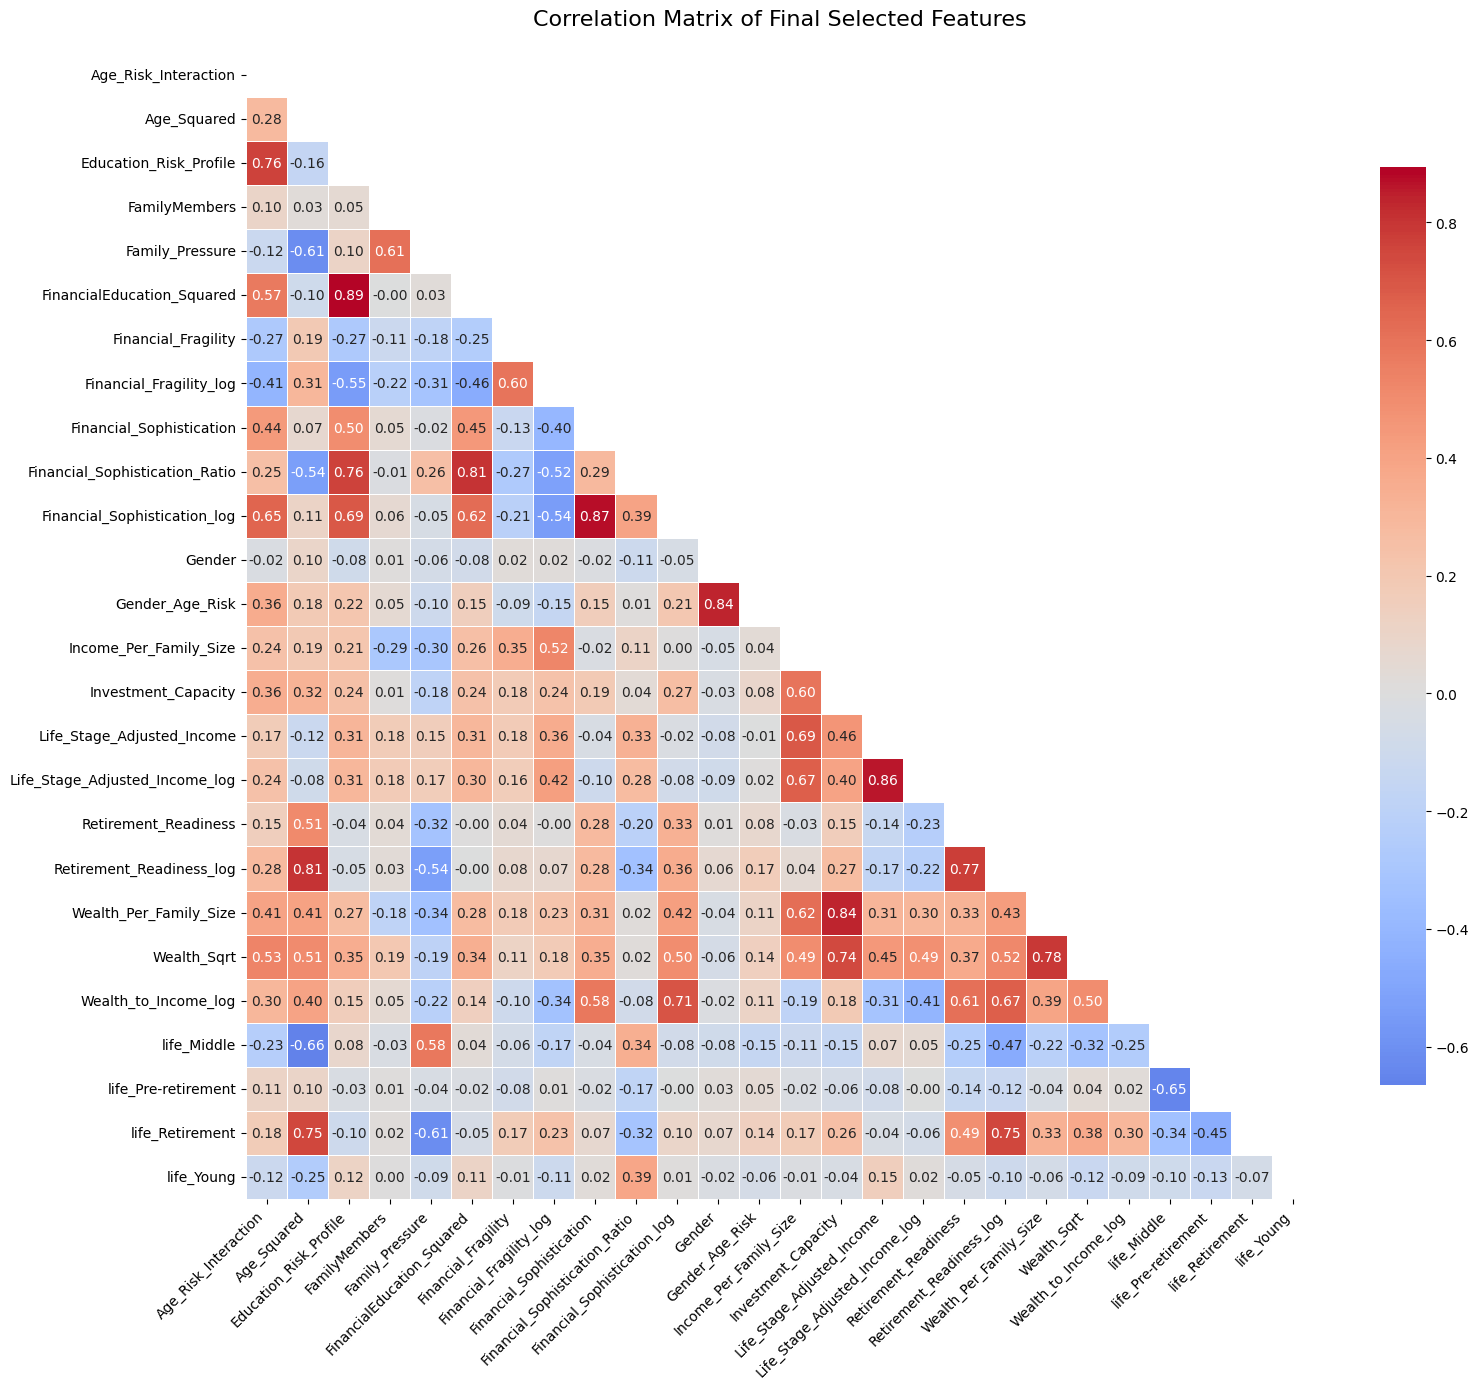


Feature Engineering Summary:
Baseline features: 9
Engineered features (after feature selection): 26

Top 10 features by correlation with targets:
- Wealth_Sqrt: Income=0.438, Accumulation=0.128
- Retirement_Readiness_log: Income=0.381, Accumulation=-0.029
- life_Retirement: Income=0.375, Accumulation=-0.001
- Age_Squared: Income=0.348, Accumulation=-0.009
- Wealth_Per_Family_Size: Income=0.342, Accumulation=0.113
- Life_Stage_Adjusted_Income_log: Income=0.115, Accumulation=0.333
- Life_Stage_Adjusted_Income: Income=0.080, Accumulation=0.297
- Wealth_to_Income_log: Income=0.295, Accumulation=-0.195
- Investment_Capacity: Income=0.260, Accumulation=0.161
- Retirement_Readiness: Income=0.246, Accumulation=0.007

Preprocessing complete. Both baseline and engineered datasets are ready for modeling.
Baseline: X ((5000, 9)), y_income ((5000,)), y_accum ((5000,))
Engineered: X ((5000, 26)), y_income ((5000,)), y_accum ((5000,))


In [6]:
# =====================================================================================
# PART 1: BASELINE DATASET WITH MINIMAL PREPROCESSING
# =====================================================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Load and examine the dataset
print("CREATING BASELINE DATASET")
print("=========================")

# Start with dataset that already has ID removed
baseline_df = needs_df_no_id.copy()

# Print basic information about the dataset
print(f"Dataset shape: {baseline_df.shape}")
print(f"Target distribution - Income Investment: \n{baseline_df['IncomeInvestment'].value_counts(normalize=True).round(3) * 100}%")
print(f"Target distribution - Accumulation Investment: \n{baseline_df['AccumulationInvestment'].value_counts(normalize=True).round(3) * 100}%")

# 2. Basic preprocessing for baseline dataset
# Log transform highly skewed financial variables
baseline_df['Wealth_log'] = np.log1p(baseline_df['Wealth'])
baseline_df['Income_log'] = np.log1p(baseline_df['Income'])

# Scale all numeric features
baseline_scaler = MinMaxScaler()
baseline_numeric = baseline_df.select_dtypes(include=['float64', 'int64']).columns
baseline_df[baseline_numeric] = baseline_scaler.fit_transform(baseline_df[baseline_numeric])

# 3. Split into features and targets
baseline_X = baseline_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
baseline_y_income = baseline_df['IncomeInvestment']
baseline_y_accum = baseline_df['AccumulationInvestment']

# 4. Baseline dataset summary
print("\nBaseline Dataset Summary:")
print(f"Number of features: {baseline_X.shape[1]}")
print(f"Feature list: {baseline_X.columns.tolist()}")

# =====================================================================================
# PART 2: FEATURE-ENGINEERED DATASET WITH ADVANCED PREPROCESSING
# =====================================================================================

print("\n\nCREATING FEATURE-ENGINEERED DATASET")
print("===================================")

# 1. Start fresh with original data
engineered_df = needs_df_no_id.copy()

# 2. Visualize original distributions
print("Visualizing original data distributions...")
plt.figure(figsize=(15, 10))
for i, column in enumerate(engineered_df.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(engineered_df[column], kde=True)
    plt.title(f'Original {column} Distribution')
plt.tight_layout()
plt.show()

# Add boxplots for outlier detection
print("\nGenerating box plots to identify outliers...")
plt.figure(figsize=(18, 10))
plt.suptitle('Box Plots of Financial Variables - Outlier Detection', fontsize=16)
for i, col in enumerate(['Wealth', 'Income', 'Age', 'RiskPropensity', 'FinancialEducation']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=engineered_df[col])
    plt.title(f'{col}')
    plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# 3. Analyze relationship between target variables
y_income = engineered_df['IncomeInvestment']
y_accum = engineered_df['AccumulationInvestment']
target_correlation = np.corrcoef(y_income, y_accum)[0, 1]
print(f"Correlation between Incomeand Accumulation Investment needs: {target_correlation:.3f}")

# Visualize the relationship between targets
plt.figure(figsize=(8, 6))
plt.scatter(y_income, y_accum, alpha=0.5)
plt.title(f'Relationship Between Target Variables (Correlation: {target_correlation:.3f})')
plt.xlabel('Income Investment Need')
plt.ylabel('Accumulation Investment Need')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Create target interaction features if appropriate
if abs(target_correlation) > 0.2:  # Threshold for meaningful relationship
    # Create composite target score for multi-task learning
    engineered_df['Combined_Investment_Score'] = y_income + y_accum
    print(f"Created Combined_Investment_Score with distribution:")
    print(engineered_df['Combined_Investment_Score'].value_counts(normalize=True).round(3) * 100, "%")

# 4. FEATURE ENGINEERING
print("\nPerforming advanced feature engineering...")

# Financial ratio features
engineered_df['Wealth_to_Income'] = engineered_df['Wealth'] / engineered_df['Income']
engineered_df['Financial_Capacity'] = engineered_df['Income'] + (engineered_df['Wealth'] * 0.05)
engineered_df['Wealth_Per_Family_Size'] = engineered_df['Wealth'] / engineered_df['FamilyMembers']
engineered_df['Income_Per_Family_Size'] = engineered_df['Income'] / engineered_df['FamilyMembers']

# Interaction features
engineered_df['Age_Risk_Interaction'] = engineered_df['Age'] * engineered_df['RiskPropensity']
engineered_df['Education_Risk_Profile'] = engineered_df['FinancialEducation'] * engineered_df['RiskPropensity']
engineered_df['Age_Squared'] = engineered_df['Age'] ** 2

# Add domain-specific financial features
engineered_df['Risk_Capacity'] = engineered_df['Wealth'] / (engineered_df['Age'] + 1)
engineered_df['Life_Stage_Adjusted_Income'] = engineered_df['Income'] / (engineered_df['Age'] / 50)
engineered_df['Financial_Sophistication'] = (engineered_df['FinancialEducation'] * 
                                           engineered_df['Wealth_to_Income'] * 
                                           engineered_df['RiskPropensity'])

# Add more advanced engineered features

# 1. Life-Cycle Financial Metrics
# Retirement Readiness Ratio (using Age as proxy for years to retirement)
engineered_df['Retirement_Readiness'] = engineered_df['Wealth'] / ((engineered_df['Income'] * 0.7) * np.maximum(1, 65 - engineered_df['Age']))

# Time-to-Financial-Independence (assuming 25x annual expenses needed)
engineered_df['Financial_Independence_Score'] = engineered_df['Wealth'] / (engineered_df['Income'] * 25)

# 2. Risk and Volatility Measures
# Diversification Proxy - wealth concentration relative to age and income
engineered_df['Wealth_Concentration'] = engineered_df['Wealth'] / (engineered_df['Income'] * engineered_df['Age']/10)

# Financial Fragility Score - vulnerability to financial shocks
engineered_df['Financial_Fragility'] = engineered_df['Income_Per_Family_Size'] / (engineered_df['FinancialEducation'] * engineered_df['RiskPropensity'])

# Life stage categorization - only in the engineered dataset
engineered_df['Life_Stage'] = pd.cut(engineered_df['Age'], 
                                      bins=[0, 30, 50, 65, 100],
                                      labels=['Young', 'Middle', 'Pre-retirement', 'Retirement'])

# 3. Demographic and Behavioral Indicators
# Gender-Age-Risk Triple Interaction
engineered_df['Gender_Age_Risk'] = engineered_df['Gender'] * engineered_df['Age'] * engineered_df['RiskPropensity']

# 4. Non-Linear Transformations
# Polynomial terms for key variables
engineered_df['RiskPropensity_Squared'] = engineered_df['RiskPropensity'] ** 2
engineered_df['FinancialEducation_Squared'] = engineered_df['FinancialEducation'] ** 2

# Root transformations
engineered_df['Wealth_Sqrt'] = np.sqrt(engineered_df['Wealth'])
engineered_df['Income_Cbrt'] = np.cbrt(engineered_df['Income'])

# 5. Financial Behavior Composites
# Investment Capacity Score
engineered_df['Investment_Capacity'] = engineered_df['Income'] * engineered_df['Wealth'] * (1-(engineered_df['FamilyMembers']/6))

# Financial Sophistication Ratio - education relative to age
engineered_df['Financial_Sophistication_Ratio'] = engineered_df['FinancialEducation'] / engineered_df['Age']

# 5. LOG TRANSFORMATIONS
# Apply log transformations to financial variables
financial_vars = [
    'Wealth', 'Income', 'Wealth_to_Income', 'Financial_Capacity',
    'Wealth_Per_Family_Size', 'Income_Per_Family_Size',
    'Risk_Capacity', 'Life_Stage_Adjusted_Income', 'Financial_Sophistication',
    # Add new financial features
    'Retirement_Readiness', 'Financial_Independence_Score', 
    'Wealth_Concentration', 'Financial_Fragility',
    'Investment_Capacity'
]

for var in financial_vars:
    engineered_df[f'{var}_log'] = np.log1p(engineered_df[var])

# 6. VISUALIZE TRANSFORMATIONS
# Create comparison plots for original vs log-transformed variables
for var in financial_vars[:6]:  # Show only the main financial variables
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original distribution
    sns.histplot(engineered_df[var], kde=True, ax=axes[0])
    axes[0].set_title(f'Original {var}')
    
    # Log-transformed distribution
    sns.histplot(engineered_df[f'{var}_log'], kde=True, ax=axes[1])
    axes[1].set_title(f'Log-transformed {var}')
    
    plt.tight_layout()
    plt.show()

# 7. ENCODE CATEGORICAL VARIABLES
# For neural networks, converting categorical variables to numeric is necessary
# Since Gender is already binary (0/1), we only need to one-hot encode Life_Stage
engineered_df = pd.get_dummies(engineered_df, columns=['Life_Stage'], prefix=['life'])

# Add Life-Stage Financial Pressure after one-hot encoding
engineered_df['Family_Pressure'] = engineered_df['FamilyMembers'] * (
    engineered_df['life_Young'] * 0.5 + 
    engineered_df['life_Middle'] * 1.0 + 
    engineered_df['life_Pre-retirement'] * 0.7 + 
    engineered_df['life_Retirement'] * 0.3
)

# 8. NORMALIZE/SCALE FEATURES
numeric_features = engineered_df.select_dtypes(include=['float64', 'int64']).columns
engineered_scaler = MinMaxScaler()
engineered_df[numeric_features] = engineered_scaler.fit_transform(engineered_df[numeric_features])

# 9. ANALYZE CORRELATION WITH TARGETS
# Calculate correlation with target variables
income_corr = engineered_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)\
                           .apply(lambda x: x.corr(engineered_df['IncomeInvestment']))
accum_corr = engineered_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)\
                          .apply(lambda x: x.corr(engineered_df['AccumulationInvestment']))

# Visualize correlations with targets
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
income_corr.sort_values().plot(kind='barh')
plt.title('Correlation with Income Investment Need')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.subplot(2, 1, 2)
accum_corr.sort_values().plot(kind='barh')
plt.title('Correlation with Accumulation Investment Need')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# 10. EXAMINE FEATURE CORRELATION
feature_cols = engineered_df.columns.difference(['IncomeInvestment', 'AccumulationInvestment'])
corr_matrix = engineered_df[feature_cols].corr().abs()

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, 
            annot=False,
            cmap='coolwarm', 
            center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 11. FEATURE SELECTION WITH INCREASED THRESHOLD (0.9 instead of 0.85)
# Find highly correlated feature pairs (>0.9)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) 
                   for i, j in zip(*np.where(upper_tri > 0.9))]

print("\nHighly correlated feature pairs (>0.9):")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")

# Create a list of pairs where an original feature and its log version are correlated
original_log_pairs = []
for var1, var2, corr in high_corr_pairs:
    # Check if one is the log version of the other
    for financial_var in financial_vars:
        if (var1 == financial_var and var2 == f"{financial_var}_log") or \
           (var2 == financial_var and var1 == f"{financial_var}_log"):
            original_log_pairs.append((var1, var2, corr))

# For these pairs, generally prefer the log version for financial variables
print("\nOriginal-Log version pairs:")
to_drop = set()
for var1, var2, corr in original_log_pairs:
    # Determine which is the original and which is the log version
    if '_log' in var1:
        original, log_version = var2, var1
    else:
        original, log_version = var1, var2
        
    # For financial variables, prefer log version unless original has higher correlation
    orig_max_corr = max(abs(income_corr[original]), abs(accum_corr[original]))
    log_max_corr = max(abs(income_corr[log_version]), abs(accum_corr[log_version]))
    
    if log_max_corr >= orig_max_corr:
        to_drop.add(original)
        keep = log_version
    else:
        to_drop.add(log_version)
        keep = original
        
    print(f"Original: {original}, Log: {log_version} -> Keeping: {keep}")

# For other highly correlated pairs (not original-log pairs)
other_pairs = [p for p in high_corr_pairs if p not in original_log_pairs]
for var1, var2, _ in other_pairs:
    # Keep the one with higher correlation to targets
    var1_max_corr = max(abs(income_corr[var1]), abs(accum_corr[var1]))
    var2_max_corr = max(abs(income_corr[var2]), abs(accum_corr[var2]))
    
    if var1_max_corr >= var2_max_corr:
        to_drop.add(var2)
    else:
        to_drop.add(var1)

print(f"\nFeatures dropped due to high correlation: {sorted(to_drop)}")
engineered_final_df = engineered_df.drop(to_drop, axis=1)

# Visualize correlation matrix of final features
print("\nCorrelation Matrix of Final Selected Features:")
final_feature_cols = engineered_final_df.columns.difference(['IncomeInvestment', 'AccumulationInvestment'])
final_corr_matrix = engineered_final_df[final_feature_cols].corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(final_corr_matrix, dtype=bool))  # Create a mask for the upper triangle
sns.heatmap(final_corr_matrix, 
            mask=mask,  # Only show lower triangle
            annot=True,  # Show correlation values
            cmap='coolwarm', 
            center=0,
            fmt='.2f',  # Format to 2 decimal places
            linewidths=0.5,
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Final Selected Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 12. PREPARE FINAL DATASETS
engineered_X = engineered_final_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
engineered_y_income = engineered_final_df['IncomeInvestment']
engineered_y_accum = engineered_final_df['AccumulationInvestment']

# 13. SUMMARY OF PREPROCESSING
print("\nFeature Engineering Summary:")
print(f"Baseline features: {baseline_X.shape[1]}")
print(f"Engineered features (after feature selection): {engineered_X.shape[1]}")

# Print correlation with targets for top features
print("\nTop 10 features by correlation with targets:")
# Combine correlations from both targets
combined_corr = pd.DataFrame({
    'Income': income_corr,
    'Accumulation': accum_corr
})
combined_corr['Max_Corr'] = combined_corr.abs().max(axis=1)

# Display top features that exist in final dataset
top_features = combined_corr.sort_values('Max_Corr', ascending=False).index
top_features_in_final = [f for f in top_features if f in engineered_X.columns][:10]

for feature in top_features_in_final:
    income = income_corr[feature]
    accum = accum_corr[feature]
    print(f"- {feature}: Income={income:.3f}, Accumulation={accum:.3f}")

print("\nPreprocessing complete. Both baseline and engineered datasets are ready for modeling.")
print(f"Baseline: X ({baseline_X.shape}), y_income ({baseline_y_income.shape}), y_accum ({baseline_y_accum.shape})")
print(f"Engineered: X ({engineered_X.shape}), y_income ({engineered_y_income.shape}), y_accum ({engineered_y_accum.shape})")

# **HINTs**:

* Other **EDA ideas**:

    * You could add box plots to identify **outliers**.
    * You could add Q-Q plots to check for **normality**.
    * You might include [violin plots](https://seaborn.pydata.org/generated/seaborn.violinplot.html) for categorical variables - to observe and **compare the distribution of numeric data between multiple groups** (e.g., Gender, grouping by Financial Education, or whatever you think might make sense as a grouping variable): peaks, valleys, and tails of each group’s density curve can be compared to see where groups are similar or different.
    * You can add distribution plots, **comparing different demographic groups**.
    * For some pairs of features you can plot joint and marginal distribution to understand **dependence** (maybe a candidate response variable and a candidate explanatory variable) using a [joint plot, aka scatter histogram plot](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot).
    * ...and more.

<br>

###CLUSTERING


In [7]:
# =====================================================================================
# PART 3: CLUSTERING WITH CUSTOM DISTANCE METRICS
# =====================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import gower

print("\nCUSTOM DISTANCE-BASED CLUSTERING ANALYSIS")
print("========================================")

# Use our engineered features dataset for clustering (without normalization since we'll handle it in the distance functions)
X_for_clustering = engineered_X.copy()

# Separate numerical and categorical features
# Identify categorical features (modify as needed based on your actual dataset)
categorical_cols = [col for col in X_for_clustering.columns if 
                    col.startswith('life_') or col == 'Gender']
numerical_cols = [col for col in X_for_clustering.columns if col not in categorical_cols]

# Further separate numerical features into professional and financial education features
professional_cols = ['Age', 'Income_log', 'Wealth_log', 'FamilyMembers', 
                    'Wealth_to_Income', 'Wealth_Per_Family_Size', 'Income_Per_Family_Size']
financial_edu_cols = [col for col in numerical_cols if col not in professional_cols]

# Create separate dataframes for each feature type
X_num = X_for_clustering[numerical_cols]
X_cat = X_for_clustering[categorical_cols]
X_num_prof = X_for_clustering[[col for col in professional_cols if col in X_for_clustering.columns]]
X_num_finedu = X_for_clustering[[col for col in financial_edu_cols if col in X_for_clustering.columns]]

print(f"Total features: {X_for_clustering.shape[1]}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"  - Professional features: {X_num_prof.shape[1]}")
print(f"  - Financial education features: {X_num_finedu.shape[1]}")
print(f"Categorical features: {len(categorical_cols)}")


CUSTOM DISTANCE-BASED CLUSTERING ANALYSIS
Total features: 26
Numerical features: 21
  - Professional features: 3
  - Financial education features: 18
Categorical features: 5


In [ ]:
# -------------------------
# Custom Distance Functions
# -------------------------

def hamming_cityblock_distance_matrix(X_num, X_cat, num_weight=0.7, cat_weight=0.3):
    """
    Computes a custom distance matrix by combining:
      - Cityblock (Manhattan) distance for numerical features
      - Hamming distance for categorical features
    """
    num_dist = pdist(X_num, metric='cityblock')
    cat_dist = pdist(X_cat, metric='hamming')
    
    combined_dist = (num_weight * num_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def tanimoto_cityblock_distance_matrix(X_num, X_cat, num_weight=0.7, cat_weight=0.3):
    """
    Computes a custom distance matrix by combining:
      - Cityblock (Manhattan) distance for numerical features
      - Tanimoto (Jaccard) distance for binary categorical features.
    """
    num_dist = pdist(X_num, metric='cityblock')
    cat_dist = pdist(X_cat, metric='jaccard')  # Jaccard is equivalent to Tanimoto for binary data
    
    combined_dist = (num_weight * num_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def hamming_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                          prof_weight=0.4, finedu_weight=0.4, cat_weight=0.2):
    """
    Computes a custom distance matrix using:
      - Cityblock (Manhattan) distance for two groups of numerical features 
        (professional and fine-education)
      - Hamming distance for categorical features.
    """
    num_prof_dist = pdist(X_num_prof, metric='cityblock')
    num_finedu_dist = pdist(X_num_finedu, metric='cityblock')
    cat_dist = pdist(X_cat, metric='hamming')
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def tanimoto_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                           prof_weight=0.4, finedu_weight=0.4, cat_weight=0.2):
    """
    Computes a custom distance matrix using:
      - Cityblock (Manhattan) distance for two groups of numerical features 
        (professional and fine-education)
      - Tanimoto (Jaccard) distance for binary categorical features.
    """
    num_prof_dist = pdist(X_num_prof, metric='cityblock')
    num_finedu_dist = pdist(X_num_finedu, metric='cityblock')
    cat_dist = pdist(X_cat, metric='jaccard')  # Jaccard is equivalent to Tanimoto for binary data
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def euclidean_jaccard_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                          prof_weight=0.4, finedu_weight=0.4, cat_weight=0.2):
    """
    Computes a custom distance matrix using:
      - Euclidean distance for two groups of numerical features (professional and fine-education)
      - Jaccard (Tanimoto) distance for binary categorical features.
    """
    num_prof_dist = pdist(X_num_prof, metric='euclidean')
    num_finedu_dist = pdist(X_num_finedu, metric='euclidean')
    cat_dist = pdist(X_cat, metric='jaccard')
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def mahalanobis_hamming_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                            prof_weight=0.4, finedu_weight=0.4, cat_weight=0.2):
    """
    Computes a custom distance matrix using:
      - Mahalanobis distance for two groups of numerical features (professional and fine-education)
      - Hamming distance for categorical features.
    """
    try:
        VI_prof = np.linalg.inv(np.cov(X_num_prof.T))
    except np.linalg.LinAlgError:
        print("Warning: Covariance matrix for professional features is singular. Using pseudoinverse.")
        VI_prof = np.linalg.pinv(np.cov(X_num_prof.T))
    
    try:
        VI_finedu = np.linalg.inv(np.cov(X_num_finedu.T))
    except np.linalg.LinAlgError:
        print("Warning: Covariance matrix for fine-education features is singular. Using pseudoinverse.")
        VI_finedu = np.linalg.pinv(np.cov(X_num_finedu.T))
    
    num_prof_dist = pdist(X_num_prof, metric='mahalanobis', VI=VI_prof)
    num_finedu_dist = pdist(X_num_finedu, metric='mahalanobis', VI=VI_finedu)
    cat_dist = pdist(X_cat, metric='hamming')
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)


# -------------------------
# Create Custom Distance Matrices
# -------------------------

# Generate distance matrices with different metrics
print("\nGenerating distance matrices with different metrics...")

# Create a numeric-only version of X_for_clustering for pdist functions
X_for_clustering_numeric = X_for_clustering.select_dtypes(include=['number']).copy()

# Check if X_cat contains object dtype columns and convert to one-hot encoding
X_cat_numeric = X_cat.copy()
if X_cat.select_dtypes(include=['object']).shape[1] > 0:
    print("Converting categorical features to numeric format for distance calculations...")
    X_cat_numeric = pd.get_dummies(X_cat)

distance_matrices = {
    "Gower": gower.gower_matrix(X_for_clustering),  # Gower can handle mixed types
    "Euclidean": squareform(pdist(X_for_clustering_numeric, metric='euclidean')),
    "Manhattan": squareform(pdist(X_for_clustering_numeric, metric='cityblock')),
    "Cosine": squareform(pdist(X_for_clustering_numeric, metric='cosine')),
    "Hamming+Cityblock": hamming_cityblock_distance_matrix(X_num, X_cat_numeric),
    "Tanimoto+Cityblock": tanimoto_cityblock_distance_matrix(X_num, X_cat_numeric),
    "Hamming+Cityblock New": hamming_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat_numeric),
    "Tanimoto+Cityblock New": tanimoto_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat_numeric),
    "Euclidean+Jaccard New": euclidean_jaccard_distance_matrix_new(X_num_prof, X_num_finedu, X_cat_numeric),
    "Mahalanobis+Hamming New": mahalanobis_hamming_distance_matrix_new(X_num_prof, X_num_finedu, X_cat_numeric)
}

# Display a 5x5 sample of each distance matrix
for name, matrix in distance_matrices.items():
    print(f"\n{name} Distance (First 5x5):")
    print(matrix[:5, :5])

# -------------------------
# Visualize Data with t-SNE Using Custom Distances
# -------------------------

# Visualize using t-SNE for selected distance matrices
print("\nVisualizing data with t-SNE using different distance metrics...")

# Define perplexity range
perplexity_values = [5, 15, 30, 50]

# Select which distance matrices to visualize with t-SNE
selected_distances = [
    "Tanimoto+Cityblock New", 
    "Gower", 
    "Euclidean+Jaccard New", 
    "Mahalanobis+Hamming New"
]

# Create a figure for each selected distance metric
for distance_name in selected_distances:
    print(f"\nGenerating t-SNE visualizations for {distance_name} distance...")
    fig, axes = plt.subplots(1, len(perplexity_values), figsize=(20, 5))
    
    for i, perplexity in enumerate(perplexity_values):
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            metric='precomputed',
            init='random',
            random_state=42
        )
        
        X_tsne = tsne.fit_transform(distance_matrices[distance_name])
        
        axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
        axes[i].set_title(f'{distance_name}\nPerplexity={perplexity}')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    plt.tight_layout()
    plt.show()


Generating distance matrices with different metrics...


ValueError: Unsupported dtype object

In [ ]:
# -------------------------
# Perform KMedoids Clustering with Different Distance Metrics
# -------------------------

# Define number of clusters to try
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Store clustering results for different distance metrics
cluster_results = {}

# Initialize list to hold all KMedoids models for later use
kmedoids_models = {}

print("\nPerforming KMedoids clustering with different distance metrics...")

for metric_name, dist_matrix in distance_matrices.items():
    print(f"\nClustering with {metric_name} distance:")
    cluster_results[metric_name] = {}
    kmedoids_models[metric_name] = {}
    
    for k in k_values:
        print(f"  k={k}...")
        
        # Run KMedoids using precomputed distances
        try:
            kmedoids = KMedoids(
                n_clusters=k, 
                metric='precomputed',
                random_state=42,
                init='k-medoids++',
                max_iter=300
            )
            labels = kmedoids.fit_predict(dist_matrix)
            
            # Store clustering results and model
            cluster_results[metric_name][k] = labels
            kmedoids_models[metric_name][k] = kmedoids
        except Exception as e:
            print(f"  ⚠️ Error with {metric_name}, k={k}: {e}")

print("\n✅ Clustering completed for all distance metrics")

In [ ]:
# -------------------------
# Evaluate Clustering Quality
# -------------------------

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Function to calculate Dunn index (higher is better)
def dunn_index(dist_matrix, labels):
    unique_clusters = np.unique(labels)
    n_clusters = len(unique_clusters)
    
    if n_clusters <= 1:
        return 0  # Dunn index is undefined for single cluster
    
    # Calculate max intra-cluster distance for each cluster
    max_intra_dist = []
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        if len(cluster_indices) <= 1:
            max_intra_dist.append(0)  # Single point cluster has 0 intra-distance
            continue
        
        cluster_dist = dist_matrix[np.ix_(cluster_indices, cluster_indices)]
        max_intra_dist.append(np.max(cluster_dist))
    
    # Calculate min inter-cluster distance
    min_inter_dist = float('inf')
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            indices_i = np.where(labels == i)[0]
            indices_j = np.where(labels == j)[0]
            
            if len(indices_i) == 0 or len(indices_j) == 0:
                continue
                
            inter_dist = dist_matrix[np.ix_(indices_i, indices_j)]
            min_dist = np.min(inter_dist)
            min_inter_dist = min(min_inter_dist, min_dist)
    
    if min_inter_dist == float('inf') or max(max_intra_dist) == 0:
        return 0
    
    return min_inter_dist / max(max_intra_dist)

# Evaluate clustering results
print("\nEvaluating clustering quality...")

# Dictionary to store evaluation metrics
evaluation_metrics = {
    metric_name: {
        "silhouette": [],
        "davies_bouldin": [],
        "dunn_index": [],
        "k_values": []
    } for metric_name in distance_matrices.keys()
}

for metric_name, k_clusters in cluster_results.items():
    print(f"\nEvaluating {metric_name} clusters:")
    
    for k, labels in k_clusters.items():
        try:
            # Silhouette score (higher is better)
            sil_score = silhouette_score(
                distance_matrices[metric_name], 
                labels, 
                metric='precomputed'
            )
            
            # Davies-Bouldin score (lower is better)
            # We need original data for this, not distance matrix
            db_score = davies_bouldin_score(X_for_clustering, labels)
            
            # Dunn index (higher is better)
            dunn = dunn_index(distance_matrices[metric_name], labels)
            
            # Store metrics
            evaluation_metrics[metric_name]["silhouette"].append(sil_score)
            evaluation_metrics[metric_name]["davies_bouldin"].append(db_score)
            evaluation_metrics[metric_name]["dunn_index"].append(dunn)
            evaluation_metrics[metric_name]["k_values"].append(k)
            
            print(f"  k={k}: Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}, Dunn={dunn:.3f}")
        except Exception as e:
            print(f"  ⚠️ Error evaluating {metric_name}, k={k}: {e}")

# Visualize the evaluation metrics
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Plot Silhouette scores (higher is better)
for metric_name, metrics in evaluation_metrics.items():
    if not metrics["silhouette"]:  # Skip if empty
        continue
    if metric_name in ["Tanimoto+Cityblock New", "Gower", "Euclidean+Jaccard New"]:
        axes[0].plot(
            metrics["k_values"], 
            metrics["silhouette"], 
            'o-', 
            linewidth=2.5,
            label=metric_name
        )
    else:
        axes[0].plot(
            metrics["k_values"], 
            metrics["silhouette"], 
            'o--', 
            alpha=0.6,
            label=metric_name
        )
axes[0].set_title('Silhouette Score by Number of Clusters (Higher is Better)')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')

# Plot Davies-Bouldin scores (lower is better)
for metric_name, metrics in evaluation_metrics.items():
    if not metrics["davies_bouldin"]:  # Skip if empty
        continue
    if metric_name in ["Tanimoto+Cityblock New", "Gower", "Euclidean+Jaccard New"]:
        axes[1].plot(
            metrics["k_values"], 
            metrics["davies_bouldin"], 
            'o-', 
            linewidth=2.5,
            label=metric_name
        )
    else:
        axes[1].plot(
            metrics["k_values"], 
            metrics["davies_bouldin"], 
            'o--', 
            alpha=0.6,
            label=metric_name
        )
axes[1].set_title('Davies-Bouldin Score by Number of Clusters (Lower is Better)')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best')

# Plot Dunn index (higher is better)
for metric_name, metrics in evaluation_metrics.items():
    if not metrics["dunn_index"]:  # Skip if empty
        continue
    if metric_name in ["Tanimoto+Cityblock New", "Gower", "Euclidean+Jaccard New"]:
        axes[2].plot(
            metrics["k_values"], 
            metrics["dunn_index"], 
            'o-', 
            linewidth=2.5,
            label=metric_name
        )
    else:
        axes[2].plot(
            metrics["k_values"], 
            metrics["dunn_index"], 
            'o--', 
            alpha=0.6,
            label=metric_name
        )
axes[2].set_title('Dunn Index by Number of Clusters (Higher is Better)')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Dunn Index')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='best')

plt.tight_layout()
plt.show()

# Print recommendations for each metric
print("\nRecommended number of clusters based on evaluation metrics:")
for metric_name, metrics in evaluation_metrics.items():
    if not metrics["silhouette"] or not metrics["davies_bouldin"] or not metrics["dunn_index"]:
        continue
        
    best_k_silhouette = metrics["k_values"][np.argmax(metrics["silhouette"])]
    best_k_db = metrics["k_values"][np.argmin(metrics["davies_bouldin"])]
    best_k_dunn = metrics["k_values"][np.argmax(metrics["dunn_index"])]
    
    print(f"\n{metric_name}:")
    print(f"  Silhouette suggests k={best_k_silhouette}")
    print(f"  Davies-Bouldin suggests k={best_k_db}")
    print(f"  Dunn Index suggests k={best_k_dunn}")

In [ ]:
# -------------------------
# Interactive 3D Cluster Visualization
# -------------------------
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import warnings

# Filter out the specific t-SNE warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.manifold._t_sne")

# Set distance metric, number of clusters and perplexity
distance_metric = "Cosine"  # Change this to match your distance_matrices key exactly
num_clusters = 7  # Change this to your desired K value
perplexity_value = 45  # Adjust based on your dataset size

# Verify the selection exists in your results
if distance_metric not in distance_matrices:
    print(f"⚠️ Distance metric '{distance_metric}' not found. Available metrics: {list(distance_matrices.keys())}")
    # Use the first available metric as fallback
    distance_metric = list(distance_matrices.keys())[0]
    print(f"Using '{distance_metric}' instead")

if num_clusters not in cluster_results[distance_metric]:
    print(f"⚠️ K={num_clusters} not found for '{distance_metric}'. Available K values: {list(cluster_results[distance_metric].keys())}")
    # Use the first available K as fallback
    num_clusters = list(cluster_results[distance_metric].keys())[0]
    print(f"Using K={num_clusters} instead")

# Get the distance matrix and labels
dist_matrix = distance_matrices[distance_metric]
labels = cluster_results[distance_metric][num_clusters]

# Check if the distance matrix is valid
if np.isnan(dist_matrix).any() or np.isinf(dist_matrix).any():
    print(f"⚠️ Distance matrix contains NaN or Inf values - fixing...")
    # Replace NaN/Inf with large values
    dist_matrix = np.nan_to_num(dist_matrix, nan=np.nanmax(dist_matrix)*2, 
                             posinf=np.nanmax(dist_matrix)*2, 
                             neginf=np.nanmin(dist_matrix)*2)

# Compute 3D t-SNE projection with square_distances=True to avoid warnings
tsne = TSNE(
    n_components=3, 
    metric='precomputed', 
    init='random', 
    random_state=42, 
    perplexity=perplexity_value,
    square_distances=True  # Add this to avoid warnings
)
X_tsne_3d = tsne.fit_transform(dist_matrix)

# Create DataFrame for visualization - make sure cluster is numeric
df_plot = pd.DataFrame({
    'x': X_tsne_3d[:, 0], 
    'y': X_tsne_3d[:, 1], 
    'z': X_tsne_3d[:, 2], 
    'Cluster': labels.astype(int)  # Ensure cluster labels are integers
})

# Add target variables for hover information
df_plot['IncomeInvestment'] = engineered_y_income.values
df_plot['AccumulationInvestment'] = engineered_y_accum.values

# Create the 3D scatter plot using a color map approach
# Define unique colors for each cluster
num_unique_clusters = len(np.unique(labels))
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
]

# Create color mapping
color_map = {i: colors[i % len(colors)] for i in range(num_unique_clusters)}
df_plot['color'] = df_plot['Cluster'].map(color_map)

# Create hover text
hover_text = [
    f"Cluster: {c}<br>Income Need: {i}<br>Accum Need: {a}" 
    for c, i, a in zip(
        df_plot['Cluster'], 
        df_plot['IncomeInvestment'], 
        df_plot['AccumulationInvestment']
    )
]

# Create a separate trace for each cluster for better visualization
fig = go.Figure()

for cluster_id in sorted(df_plot['Cluster'].unique()):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
    cluster_hover = [t for i, t in enumerate(hover_text) if df_plot['Cluster'].iloc[i] == cluster_id]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data['x'],
        y=cluster_data['y'],
        z=cluster_data['z'],
        mode='markers',
        marker=dict(
            size=5,
            color=color_map[cluster_id],
            opacity=0.8
        ),
        text=cluster_hover,
        hoverinfo='text',
        name=f'Cluster {cluster_id}'
    ))

# Customize layout
fig.update_layout(
    title=f"3D t-SNE Cluster Visualization<br>({distance_metric}, k={num_clusters}, perplexity={perplexity_value})",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=1000,  # Width of the figure
    height=800   # Height of the figure
)

# Display the interactive plot
fig.show()

# Print cluster information
print("\nCluster sizes:")
for cluster in sorted(np.unique(labels)):
    size = np.sum(labels == cluster)
    print(f"  Cluster {cluster}: {size} clients ({size/len(labels)*100:.1f}%)")

# Analyze investment needs by cluster
cluster_df = pd.DataFrame({
    'Cluster': labels,
    'IncomeInvestment': engineered_y_income.values,
    'AccumulationInvestment': engineered_y_accum.values
})

investment_by_cluster = cluster_df.groupby('Cluster')[['IncomeInvestment', 'AccumulationInvestment']].mean() * 100
print("\nInvestment Need Distribution by Cluster:")
print(investment_by_cluster.round(1).astype(str) + '%')

In [ ]:
# -------------------------
# Complete Cluster Centroids Table with All Columns
# -------------------------
import pandas as pd
import numpy as np
from IPython.display import display

# Set pandas to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Wider display
pd.set_option('display.max_colwidth', 20)   # Limit column width for readability

# Create a DataFrame with cluster labels
cluster_data = X_for_clustering.copy()
cluster_data['Cluster'] = labels

# Add investment needs
cluster_data['IncomeInvestment'] = engineered_y_income.values
cluster_data['AccumulationInvestment'] = engineered_y_accum.values

# Calculate mean values for each feature by cluster
centroids = cluster_data.groupby('Cluster').mean()

# Calculate cluster sizes
cluster_sizes = pd.Series(labels).value_counts().sort_index()
size_percentages = (cluster_sizes / len(labels) * 100).round(1)

# Add cluster size information
centroids['Cluster_Size'] = cluster_sizes.values
centroids['Cluster_Percentage'] = size_percentages.values

# Convert the investment needs to percentages for clarity
centroids['IncomeInvestment'] = (centroids['IncomeInvestment'] * 100).round(1)
centroids['AccumulationInvestment'] = (centroids['AccumulationInvestment'] * 100).round(1)

# Round numerical values for better readability
centroids_rounded = centroids.round(3)

# Create a more readable order of columns
# First get all feature columns except the ones we just added
feature_cols = [col for col in centroids.columns 
                if col not in ['Cluster_Size', 'Cluster_Percentage', 
                              'IncomeInvestment', 'AccumulationInvestment']]

# Reorder columns: size metrics first, then investment needs, then features
ordered_cols = ['Cluster_Size', 'Cluster_Percentage', 
                'IncomeInvestment', 'AccumulationInvestment'] + feature_cols

# Reindex to get our preferred column order
if all(col in centroids_rounded.columns for col in ordered_cols):
    centroids_rounded = centroids_rounded[ordered_cols]

# Add % symbol to percentage columns
centroids_display = centroids_rounded.copy()
centroids_display['Cluster_Percentage'] = centroids_display['Cluster_Percentage'].astype(str) + '%'
centroids_display['IncomeInvestment'] = centroids_display['IncomeInvestment'].astype(str) + '%'
centroids_display['AccumulationInvestment'] = centroids_display['AccumulationInvestment'].astype(str) + '%'

# Reset index to make Cluster a column
centroids_display = centroids_display.reset_index()

# Display the table
print("\nCluster Centroids: Mean Value of Each Feature by Cluster")
print("=" * 70)
display(centroids_display)

# If there are still too many columns, you can display them in chunks
if len(centroids_display.columns) > 20:
    print("\nDisplaying columns in chunks for better visibility:")
    
    # Display key metrics
    key_cols = ['Cluster', 'Cluster_Size', 'Cluster_Percentage', 
                'IncomeInvestment', 'AccumulationInvestment']
    print("\nKey Metrics:")
    display(centroids_display[key_cols])
    
    # Display financial features (select some important ones)
    financial_cols = [col for col in centroids_display.columns if 
                     any(term in col for term in ['Wealth', 'Income', 'Financial', 'Risk'])]
    financial_cols = ['Cluster'] + financial_cols[:10]  # Limit to 10 financial features
    print("\nKey Financial Features:")
    display(centroids_display[financial_cols])
    
    # Display demographic features
    demo_cols = [col for col in centroids_display.columns if 
                any(term in col for term in ['Age', 'Gender', 'Family'])]
    demo_cols = ['Cluster'] + demo_cols
    print("\nDemographic Features:")
    display(centroids_display[demo_cols])
    
    # You can continue with more specific feature groups as needed

# Save full table to CSV for external viewing
try:
    csv_path = 'cluster_centroids_full.csv'
    centroids_rounded.to_csv(csv_path)
    print(f"\nFull table with all columns saved to {csv_path}")
except Exception as e:
    print(f"Could not save to CSV: {e}")

# Restore pandas display options to defaults
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

# HINT:
* Try to **engineer your features** using some financial knowledge (maybe you can find a rationale for the number of family members, the gender, maybe it's linked to the client's life-cycle or whatever).
* Try one or more **other baseline models** - memento: baseline models are relatively simple, so K-NN, SVM, Decision Trees, Logistic Regression, etc. may work well. BTW, simple does not mean that they do not work well: sometimes they generalize well and do not overfit, and often they are easier to interpret (think of logistic regression, which has parameters, the coefficients, directly interpretable).

<br>

Looking at our results, XGBoost performs excellently, with good F1, and a very balanced precision and recall.

The base features still consistently outperform the engineered features, suggesting we should stick with the original feature set, sorry for domain knowledge...

<br>



In [ ]:
# PART 4: CLUSTER-SPECIFIC NEURAL NETWORKS FOR PREDICTION

print("\n===== Building Neural Network Models for Each Cluster =====")

# Save final cluster labels for later use
# Use the existing labels from your clustering
final_cluster_labels = labels  # This should work as your notebook already has this variable

# Import necessary libraries if not already imported
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to create a neural network model
def create_nn_model(input_dim):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        # Hidden layers
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        # Output layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# Create dictionaries to store data and models for each cluster
cluster_data = {}
income_models = {}
accum_models = {}
results = {}

# Add engineered features and target variables
df_for_nn = engineered_final_df.copy()  # Using your existing engineered features dataframe
df_for_nn['cluster'] = labels  # Using your existing labels

# Display cluster distribution
print("Cluster distribution:")
cluster_counts = pd.Series(labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} samples ({count/len(labels)*100:.1f}%)")

# Process each cluster
for cluster_id in np.unique(labels):
    print(f"\n--- Processing Cluster {cluster_id} ---")
    
    # Filter data for this cluster
    cluster_df = df_for_nn[df_for_nn['cluster'] == cluster_id]
    
    # Skip small clusters
    if len(cluster_df) < 30:
        print(f"Cluster {cluster_id} has only {len(cluster_df)} samples. Skipping...")
        continue
    
    # For each target variable (Income Investment and Accumulation Investment)
    for target_name in ['IncomeInvestment', 'AccumulationInvestment']:
        print(f"\nTraining model for {target_name} in Cluster {cluster_id}")
        
        # Prepare features and target
        X = cluster_df.drop(['IncomeInvestment', 'AccumulationInvestment', 'cluster'], axis=1)
        y = cluster_df[target_name]
        
        # One-hot encode categorical features if any
        X = pd.get_dummies(X)
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Calculate class weights for imbalanced data
        classes = np.unique(y_train)
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_train
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        # Create callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
        ]
        
        # Create and train model
        model = create_nn_model(X_train_scaled.shape[1])
        
        # Train model
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50,  # Reduced for notebook execution speed
            batch_size=32,
            validation_data=(X_test_scaled, y_test),
            callbacks=callbacks,
            class_weight=class_weight_dict,
            verbose=1
        )
        
        # Evaluate model
        y_pred_prob = model.predict(X_test_scaled)
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Only calculate AUC if we have both classes
        if len(np.unique(y_test)) > 1:
            auc = roc_auc_score(y_test, y_pred_prob)
        else:
            auc = float('nan')
        
        print(f"Model Metrics:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  AUC: {auc:.4f}")
        
        # Store model and data
        if target_name == 'IncomeInvestment':
            income_models[cluster_id] = {
                'model': model,
                'scaler': scaler,
                'feature_names': X.columns.tolist(),
                'metrics': {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc
                }
            }
        else:
            accum_models[cluster_id] = {
                'model': model,
                'scaler': scaler,
                'feature_names': X.columns.tolist(),
                'metrics': {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc
                }
            }
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'Cluster {cluster_id} - {target_name} Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Cluster {cluster_id} - {target_name} Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        
        plt.tight_layout()
        plt.show()

# Visualize the comparison of models
# Create a dataframe with all model metrics for comparison
metrics_comparison = []

for model_type, models_dict in [('Income', income_models), ('Accumulation', accum_models)]:
    for cluster_id, model_data in models_dict.items():
        metrics_comparison.append({
            'Model Type': model_type,
            'Cluster': f'Cluster {cluster_id}',
            'Accuracy': model_data['metrics']['accuracy'],
            'Precision': model_data['metrics']['precision'],
            'Recall': model_data['metrics']['recall'],
            'F1 Score': model_data['metrics']['f1'],
            'AUC': model_data['metrics']['auc']
        })

metrics_df = pd.DataFrame(metrics_comparison)

# Plot comparison metrics
plt.figure(figsize=(15, 10))

# Plot accuracy comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Cluster', y='Accuracy', hue='Model Type', data=metrics_df)
plt.title('Accuracy by Cluster')
plt.xticks(rotation=45)

# Plot precision comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Cluster', y='Precision', hue='Model Type', data=metrics_df)
plt.title('Precision by Cluster')
plt.xticks(rotation=45)

# Plot recall comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Cluster', y='Recall', hue='Model Type', data=metrics_df)
plt.title('Recall by Cluster')
plt.xticks(rotation=45)

# Plot F1 comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Cluster', y='F1 Score', hue='Model Type', data=metrics_df)
plt.title('F1 Score by Cluster')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n===== Neural Network Models Complete =====")
print("Cluster-specific neural networks have been trained for both IncomeInvestment and AccumulationInvestment")
print("Models are stored in 'income_models' and 'accum_models' dictionaries for prediction")

<br>

Now let's move to another class of models, a **Multilayer Perceptron (MLP) Neural Network (NN)**, a family of powerful and flexible models - and therefore at **risk of overfitting**.


## Multi-Layer Perceptron implementation

### NN architecture rationale
* **Decreasing Layer Sizes** (64 → 32 → 16 → 1): Creates a bottleneck architecture that forces the NN to learn increasingly compact representations (maybe reducing the risk of overfitting).
* **Batch Normalization**: Makes training of NN faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. [Batch Normalization](https://arxiv.org/abs/1502.03167) addresses internal covariate shift, particularly important with our mixed-scale financial features.
* **Dropout=0.2**: [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) is a light regularization that maintains most information while preventing co-adaptation. Basically, dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.
* **ReLU**: Provides non-linearity without gradient vanishing issues common in financial data modeling.
* **Sigmoid Output**: Transforms final layer output into probability scores for binary classification.

### Training configuration and reasoning
* **Binary Cross Entropy Loss**: Natural choice for binary classification with probabilistic interpretation
* **Adam Optimizer (lr=0.001)**: Adaptive learning rates help handle different feature scales.
* **Batch size=32**: Good balance between computational efficiency and gradient estimation.
* **100 epochs**: Sufficient iterations for convergence with validation monitoring every 10 epochs.

### Data handling
* Custom PyTorch Dataset class for efficient data loading.
* Separate training and evaluation pipelines.
* Comprehensive metrics evaluation (accuracy, precision, recall, F1), comparable to previous models.

<br>


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import numpy as np

# Set up device for GPU acceleration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Training function with enhanced logging
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    # Initialize tracking variables
    best_val_acc = 0
    train_losses = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    
    print(f"Starting training on {device}...")
    print(f"Training samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}")
    
    # Training loop with logging
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        batch_times = []
        
        print(f"Epoch {epoch+1}/{epochs} - Training...")
        for i, (X_batch, y_batch) in enumerate(train_loader):
            batch_start = time.time()
            
            # Move tensors to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            batch_time = time.time() - batch_start
            batch_times.append(batch_time)
            
            # Print batch info occasionally
            if i % 5 == 0:
                print(f"  Batch {i+1}/{len(train_loader)}: loss={loss.item():.4f}, time={batch_time*1000:.1f}ms", end="\r")
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        print(f"\nEpoch {epoch+1}/{epochs} - Validating...")
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Move tensors to device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                
                # Move back to CPU for numpy conversion
                val_preds.extend((y_pred > 0.5).float().cpu().numpy())
                val_true.extend(y_batch.cpu().numpy())
        
        # Calculate metrics
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        val_acc = accuracy_score(val_true, val_preds)
        val_accs.append(val_acc)
        
        val_precision = precision_score(val_true, val_preds, zero_division=0)
        val_recall = recall_score(val_true, val_preds, zero_division=0)
        val_f1 = f1_score(val_true, val_preds, zero_division=0)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            improvement = "✓ (New Best)"
        else:
            improvement = ""
        
        # Log every epoch
        epoch_time = time.time() - start_time
        time_per_epoch = epoch_time / (epoch + 1)
        estimated_remaining = time_per_epoch * (epochs - epoch - 1)
        
        print(f"\nEpoch {epoch+1}/{epochs} - {epoch_time/60:.2f}m elapsed - {estimated_remaining/60:.2f}m remaining")
        print(f"  Train Loss: {avg_train_loss:.4f} | Batch Time: {np.mean(batch_times)*1000:.2f}ms")
        print(f"  Val Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f} {improvement}")
        print(f"  Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
        
        # More detailed logs every 10 epochs or for final epoch
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            pos_count = sum(val_true)
            neg_count = len(val_true) - pos_count
            print(f"  Class Distribution - Positive: {pos_count} ({pos_count/len(val_true)*100:.1f}%) | Negative: {neg_count} ({neg_count/len(val_true)*100:.1f}%)")
            
            # GPU info if available
            if device.type == "mps":
                print(f"  Using M4 Max GPU | PyTorch Version: {torch.__version__}")
    
    print(f"\nTraining completed in {(time.time() - start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'training_time': time.time() - start_time
    }

# Evaluation function for final metrics
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            # Move input to the same device as the model
            X_batch = X_batch.to(device)
            y_batch_cpu = y_batch.clone()  # Keep a CPU copy for metrics
            
            # Forward pass
            y_pred = model(X_batch).squeeze()
            
            # Move predictions back to CPU for numpy conversion
            all_preds.extend((y_pred > 0.5).float().cpu().numpy())
            all_true.extend(y_batch_cpu.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, zero_division=0)
    recall = recall_score(all_true, all_preds, zero_division=0)
    f1 = f1_score(all_true, all_preds, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Train neural networks on both baseline and engineered datasets
for dataset_name, X, target_data in [
    ('Baseline', baseline_X, [(baseline_y_income, 'Income Investment'), (baseline_y_accum, 'Accumulation Investment')]),
    ('Advanced Engineered', engineered_X, [(engineered_y_income, 'Income Investment'), (engineered_y_accum, 'Accumulation Investment')])
]:
    for y, target_name in target_data:
        print(f"\nTraining Neural Network on {dataset_name} Dataset for {target_name}")
        print("=" * 70)

        # Split data
        X_train, X_test, y_train, y_test = split_data(X, y)

        # Create data loaders
        train_dataset = InvestmentDataset(X_train, y_train)
        test_dataset = InvestmentDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Initialize model, criterion, optimizer and move model to GPU
        model = MLP(input_size=X_train.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model with enhanced logging
        training_history = train_model(model, train_loader, test_loader, criterion, optimizer)
        
        # After training, evaluate on test set with the fixed evaluation function
        test_metrics = evaluate_nn_metrics(model, test_loader)
        
        print(f"\nFinal Test Results for {dataset_name} - {target_name}:")
        print(f"Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Precision: {test_metrics['precision']:.4f}")
        print(f"Recall: {test_metrics['recall']:.4f}")
        print(f"F1 Score: {test_metrics['f1']:.4f}")

In [ ]:
# Model evaluation with GPU support and enhanced printing
def evaluate_nn_metrics(model, data_loader):
    # Get the device the model is on
    device = next(model.parameters()).device
    print(f"Evaluating model on device: {device}")
    
    model.eval()
    all_preds = []
    all_true = []

    print("Starting evaluation...")
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(data_loader):
            # Keep original y_batch on CPU for metrics
            y_batch_cpu = y_batch.clone()
            
            # Move input to the same device as the model
            X_batch = X_batch.to(device)
            
            # Forward pass
            y_pred = model(X_batch).squeeze()
            
            # Move predictions back to CPU for numpy conversion
            all_preds.extend((y_pred > 0.5).float().cpu().numpy())
            all_true.extend(y_batch_cpu.numpy())
            
            # Print progress
            if i % 5 == 0:
                print(f"Processed {i+1}/{len(data_loader)} batches", end="\r")
    
    # Calculate metrics
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds)
    recall = recall_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds)
    
    print("\nEvaluation complete!")
    print(f"Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Evaluate and compare models on both datasets
for dataset_name, X, target_data in [
    ('Baseline', baseline_X, [(baseline_y_income, 'Income Investment'), (baseline_y_accum, 'Accumulation Investment')]),
    ('Advanced Engineered', engineered_X, [(engineered_y_income, 'Income Investment'), (engineered_y_accum, 'Accumulation Investment')])
]:
    for y, target_name in target_data:
        print(f"\nResults for {dataset_name} - {target_name}")
        print("=" * 50)

        # Split data
        X_train, X_test, y_train, y_test = split_data(X, y)

        # Create data loaders
        train_dataset = InvestmentDataset(X_train, y_train)
        test_dataset = InvestmentDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Initialize new model for this dataset/target
        model = MLP(input_size=X_train.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model (using a shorter number of epochs for demonstration)
        training_history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)

        print(f"\nEvaluating Training Set for {dataset_name} - {target_name}...")
        train_metrics = evaluate_nn_metrics(model, train_loader)
        
        print(f"\nEvaluating Test Set for {dataset_name} - {target_name}...")
        test_metrics = evaluate_nn_metrics(model, test_loader)

        # Display results
        print("\n==== Neural Network Performance Summary ====")
        metrics_df = pd.DataFrame({
            'Training': train_metrics,
            'Test': test_metrics
        }).round(3)

        print("\nNeural Network Metrics:")
        display(metrics_df)  # For Jupyter notebooks, better than print()
        
        # Also print as fallback in case display doesn't work
        print(f"\nTraining metrics: {train_metrics}")
        print(f"Test metrics: {test_metrics}")
        print("\n" + "="*50)

<br>

Good results, certainly not exceptional.

Let's take another small step forward and introduce an enhanced version that maintains the core architecture while adding more sophisticated training dynamics and monitoring capabilities.

## Enhanced MLP implementation with Learning Curves

### Key Enhancements
* **Learning rate scheduler**: Implements **ReduceLROnPlateau** for **adaptive learning rate adjustment** - it's a smart technique, look at [this paper](https://arxiv.org/abs/1506.01186) and [this other one](https://arxiv.org/abs/1803.09820):
  * Reduces learning rate by 50% after 10 epochs without improvement.
  * Helps overcome plateaus and fine-tune learning in later stages.

* **Performance monitoring**:
  * Tracks training and validation losses across epochs.
  * Monitors validation accuracy progression.
  * Stores metrics for visualization.

* **Visualization capabilities**:
  * Real-time learning curves display.
  * Side-by-side loss and accuracy plots.
  * Visual assessment of model convergence and potential overfitting. Overfitting occurs when a model **performs well on training data but poorly on validation data**. In learning curves, this appears as:  
    * **Training loss decreasing steadily**.
    * **validation loss stops improving (plateaus) or increases** after a certain epoch.
    * A **large gap** between training and validation performance indicates overfitting, suggesting the need for **regularization, more data, or early stopping**.

The idea is you should:
- Experiment better convergence through **adaptive learning rates**.
- Get visual insights into training dynamics.
- Be able to identify overfitting/underfitting.
- Overall: More informed model evaluation.

<br>

In [13]:
# Enhanced MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Training with learning rate scheduler and visualization
def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    # Move model to the appropriate device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    print(f"Training on device: {device}")
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # Move data to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Move data to device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().cpu().numpy())
                val_true.extend(y_batch.cpu().numpy())

        # Store metrics
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy_score(val_true, val_preds))

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Val Accuracy: {val_accuracies[-1]:.4f}')

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [ ]:
# Training and evaluation for both datasets and both targets
for dataset_name, X, target_data in [
    ('Baseline', baseline_X, [(baseline_y_income, 'Income Investment'), (baseline_y_accum, 'Accumulation Investment')]),
    ('Advanced Engineered', engineered_X, [(engineered_y_income, 'Income Investment'), (engineered_y_accum, 'Accumulation Investment')])
]:
    for y, target_name in target_data:
        print(f"\nTraining Neural Network on {dataset_name} Dataset for {target_name}")
        print("=" * 70)

        # Split data
        X_train, X_test, y_train, y_test = split_data(X, y)

        # Create data loaders
        train_dataset = InvestmentDataset(X_train, y_train)
        test_dataset = InvestmentDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Initialize model, criterion, optimizer
        model = MLP(input_size=X_train.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model with learning curves
        model = train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

        # Display final metrics
        print(f"\nResults for {dataset_name} - {target_name}")
        print("=" * 50)

        train_metrics = evaluate_nn_metrics(model, train_loader)
        test_metrics = evaluate_nn_metrics(model, test_loader)

        metrics_df = pd.DataFrame({
            'Training': train_metrics,
            'Test': test_metrics
        }).round(3)

        print("\nNeural Network Metrics:")
        display(metrics_df)  # For Jupyter notebooks
        
        # Also print as fallback
        print(f"\nTraining metrics: {train_metrics}")
        print(f"Test metrics: {test_metrics}")
        print("\n" + "="*50)

<br>

Short comment: these are rather strong results! The batch normalization and learning rate scheduler have improved the model's performance significantly. These results are competitive with XGBoost (particularly for Accumulation Investment prediction).

<br>

As you can see, thinking about the **NN architechture**, and **hyperparameter tuning** - broadly speaking, all aspects of the network architecture that can be changed are considered hyperparameters - can provide **significant improvements**.

<br>